## Pipeline OCR (Tesseract + OpenCV).

Langue (par défaut FR, mais bascule en EN si détecté)

Par défaut, l’OCR est en français :

DEFAULT_LANG = "fra" (côté Tesseract)

spacy.load("fr_core_news_sm", ...) (côté spaCy)

Si tu détectes que le texte est en anglais, tu fais basculer :

DEFAULT_LANG = "eng" (ou fra+eng si tu veux tolérer les deux)

spacy.load("en_core_web_sm", ...)

Trucs à modifier quand tu changes de langue :

la constante DEFAULT_LANG

le modèle spaCy chargé (fr_core_news_sm ↔ en_core_web_sm)

---

Fonctionnement global du script

Prendre une image (INPUT_FILE)

L’améliorer via le prétraitement (gris, upscale, contraste/sharpness, seuil, etc.)

Lancer Tesseract sur l’image prétraitée pour extraire le texte (OCR_TEXT)

### importation img et prétraitement

In [112]:
from typing import Optional, Sequence, Union

# Single file (PDF/TIFF/image) OR a list of images that belong to ONE document.
INPUT_FILE: Optional[Union[str, Sequence[str]]] = "image2tab.webp"


[info] Using INPUT_FILE=C:\Users\moura\OneDrive\Bureau\DMS\test\image2tab.webp


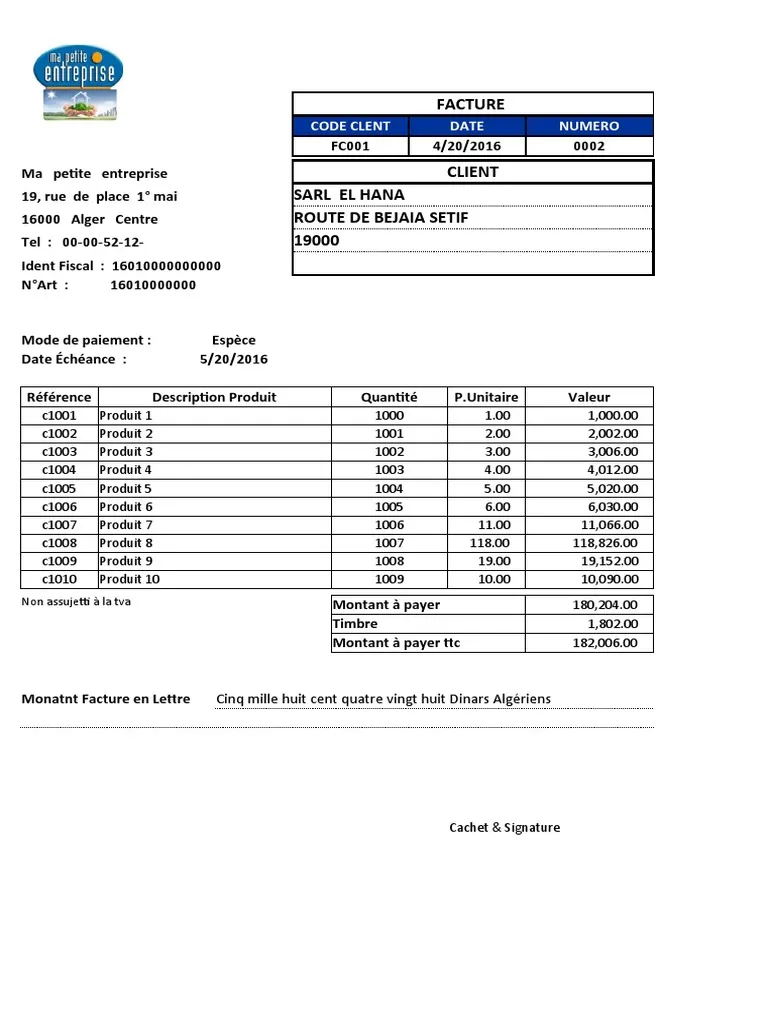

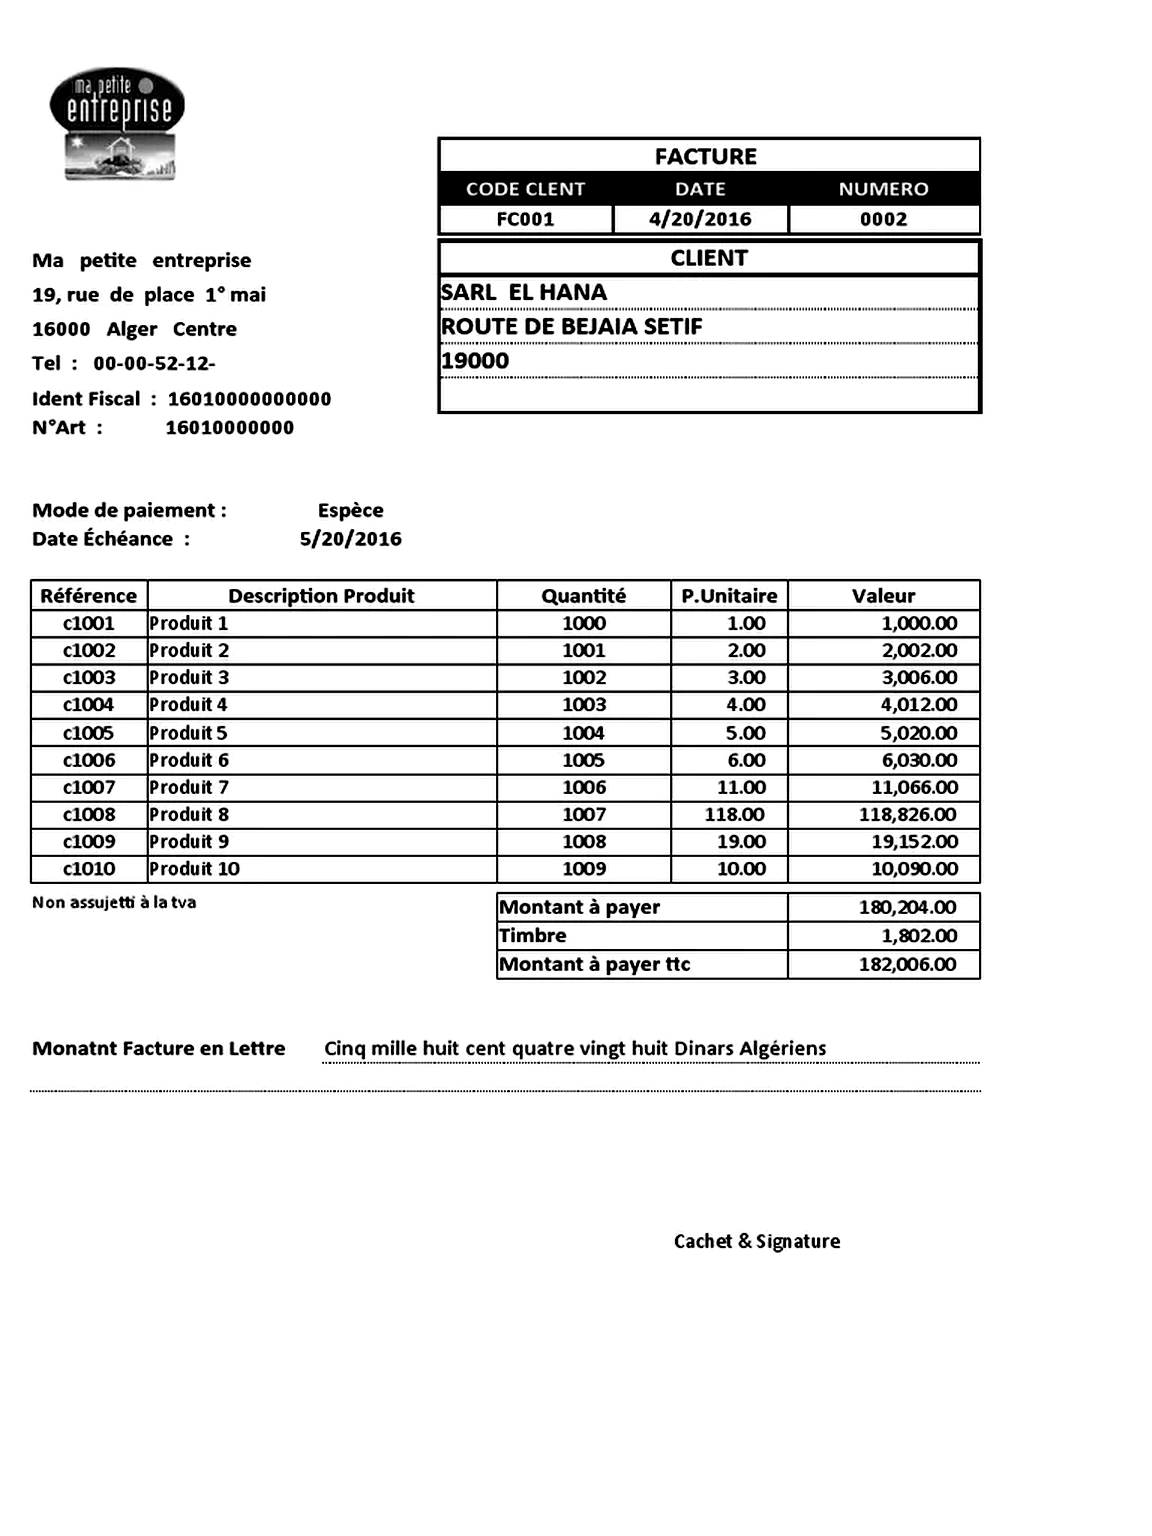

In [113]:
"""
Dependencies:
  * Python 3.8+
  * pytesseract
  * pillow
  * Tesseract binary with tessdata
"""

import argparse
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Optional, Tuple

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

try:
    import numpy as np  # type: ignore
except ImportError:  # pragma: no cover
    np = None

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # In notebooks __file__ is undefined; fall back to current working directory.
    SCRIPT_DIR = Path.cwd()

DEFAULT_LANG = "fra"
DEFAULT_CONTRAST = 1.5
DEFAULT_SHARPNESS = 1.2
DEFAULT_BRIGHTNESS = 1.0
DEFAULT_UPSCALE = 1.5
DEFAULT_DPI = 300


SHOW_PREPROCESSED = True   #/////////////////////////////////////////////////////////////////////////////////////////////////////////////////


@dataclass
class EnhanceOptions:
    contrast: float = DEFAULT_CONTRAST
    sharpness: float = DEFAULT_SHARPNESS
    brightness: float = DEFAULT_BRIGHTNESS
    upscale: float = DEFAULT_UPSCALE
    gamma: Optional[float] = None  # gamma correction; <1 brightens darks, >1 darkens
    pad: int = 0  # pixels to pad around the image
    median: Optional[int] = None  # kernel size for median filter (odd int, e.g., 3)
    unsharp_radius: Optional[float] = None  # e.g., 1.0
    unsharp_percent: int = 150
    invert: bool = False
    autocontrast_cutoff: Optional[int] = None  # 0-100; percentage to clip for autocontrast
    equalize: bool = False  # histogram equalization
    auto_rotate: bool = False  # attempt orientation detection + rotate
    otsu: bool = False  # auto-threshold with Otsu (requires numpy)
    threshold: Optional[int] = None  # 0-255; if set, applies a binary threshold


def build_config(
    oem: Optional[int],
    psm: Optional[int],
    base_flags: Iterable[str],
    dpi: Optional[int],
    tessdata_dir: Optional[Path],
    user_words: Optional[Path],
    user_patterns: Optional[Path],
) -> str:
    parts: List[str] = []
    if oem is not None:
        parts.append(f"--oem {oem}")
    if psm is not None:
        parts.append(f"--psm {psm}")
    if dpi is not None:
        parts.append(f"--dpi {dpi}")
    if tessdata_dir is not None:
        parts.append(f'--tessdata-dir "{tessdata_dir}"')
    if user_words is not None:
        parts.append(f'--user-words "{user_words}"')
    if user_patterns is not None:
        parts.append(f'--user-patterns "{user_patterns}"')
    parts.extend(base_flags)
    return " ".join(parts)


def ensure_environment(lang: str) -> None:
    try:
        _ = pytesseract.get_tesseract_version()
    except pytesseract.TesseractNotFoundError:
        sys.exit("Tesseract binary not found on PATH. Install it and its language data.")
    if lang:
        try:
            available = set(pytesseract.get_languages(config=""))
            requested = set(lang.split("+"))
            missing = requested - available
            if missing:
                print(
                    f"Warning: missing languages: {', '.join(sorted(missing))}. "
                    f"Available: {', '.join(sorted(available))}",
                    file=sys.stderr,
                )
        except pytesseract.TesseractError:
            pass


def auto_rotate_if_needed(img: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    if not enhance.auto_rotate:
        return img
    try:
        osd = pytesseract.image_to_osd(img)
        angle = None
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                try:
                    angle = int(line.split(":")[1].strip())
                except ValueError:
                    angle = None
                break
        if angle is not None and angle % 360 != 0:
            return img.rotate(-angle, expand=True)
    except Exception:
        pass
    return img


def preprocess_image(image: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    img = image.convert("L")
    img = auto_rotate_if_needed(img, enhance)

    if enhance.invert:
        img = ImageOps.invert(img)

    if enhance.pad and enhance.pad > 0:
        img = ImageOps.expand(img, border=enhance.pad, fill=255)

    if enhance.autocontrast_cutoff is not None:
        cutoff = max(0, min(100, enhance.autocontrast_cutoff))
        img = ImageOps.autocontrast(img, cutoff=cutoff)

    if enhance.equalize:
        img = ImageOps.equalize(img)

    if enhance.upscale and enhance.upscale != 1.0:
        w, h = img.size
        img = img.resize((int(w * enhance.upscale), int(h * enhance.upscale)), Image.LANCZOS)

    if enhance.gamma and enhance.gamma > 0:
        inv_gamma = 1.0 / enhance.gamma
        lut = [pow(x / 255.0, inv_gamma) * 255 for x in range(256)]
        img = img.point(lut)

    if enhance.brightness and enhance.brightness != 1.0:
        img = ImageEnhance.Brightness(img).enhance(enhance.brightness)

    if enhance.contrast and enhance.contrast != 1.0:
        img = ImageEnhance.Contrast(img).enhance(enhance.contrast)

    if enhance.sharpness and enhance.sharpness != 1.0:
        img = ImageEnhance.Sharpness(img).enhance(enhance.sharpness)

    if enhance.unsharp_radius:
        img = img.filter(
            ImageFilter.UnsharpMask(
                radius=enhance.unsharp_radius,
                percent=enhance.unsharp_percent,
                threshold=0,
            )
        )

    if enhance.median and enhance.median > 1 and enhance.median % 2 == 1:
        img = img.filter(ImageFilter.MedianFilter(size=enhance.median))

    if enhance.threshold is not None:
        thr = max(0, min(255, enhance.threshold))
        img = img.point(lambda p, t=thr: 255 if p > t else 0, mode="1").convert("L")
    elif enhance.otsu and np is not None:
        arr = np.array(img, dtype=np.uint8)
        hist, _ = np.histogram(arr, bins=256, range=(0, 256))
        total = arr.size
        sum_total = np.dot(np.arange(256), hist)

        sum_b = 0.0
        w_b = 0.0
        max_var = 0.0
        threshold = 0

        for i in range(256):
            w_b += hist[i]
            if w_b == 0:
                continue
            w_f = total - w_b
            if w_f == 0:
                break
            sum_b += i * hist[i]
            m_b = sum_b / w_b
            m_f = (sum_total - sum_b) / w_f
            var_between = w_b * w_f * (m_b - m_f) ** 2
            if var_between > max_var:
                max_var = var_between
                threshold = i

        img = img.point(lambda p, t=threshold: 255 if p > t else 0, mode="1").convert("L")

    return img


def parse_args(argv: Optional[Iterable[str]] = None) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("-l", "--lang", default=DEFAULT_LANG)
    parser.add_argument("--oem", type=int, choices=range(0, 4), default=None)
    parser.add_argument("--psm", type=int, choices=range(0, 14), default=None)
    parser.add_argument("--dpi", type=int, default=DEFAULT_DPI)
    parser.add_argument("--tessdata-dir", type=Path, default=None)
    parser.add_argument("--user-words", type=Path, default=None)
    parser.add_argument("--user-patterns", type=Path, default=None)
    parser.add_argument("--whitelist", type=str, default=None)
    parser.add_argument("--blacklist", type=str, default=None)

    parser.add_argument("--contrast", type=float, default=DEFAULT_CONTRAST)
    parser.add_argument("--sharpness", type=float, default=DEFAULT_SHARPNESS)
    parser.add_argument("--brightness", type=float, default=DEFAULT_BRIGHTNESS)
    parser.add_argument("--upscale", type=float, default=DEFAULT_UPSCALE)
    parser.add_argument("--gamma", type=float, default=None)
    parser.add_argument("--pad", type=int, default=0)
    parser.add_argument("--threshold", type=int, default=None)
    parser.add_argument("--median", type=int, default=None)
    parser.add_argument("--unsharp-radius", type=float, default=None)
    parser.add_argument("--unsharp-percent", type=int, default=150)
    parser.add_argument("--invert", action="store_true")
    parser.add_argument("--autocontrast-cutoff", type=int, default=None)
    parser.add_argument("--equalize", action="store_true")
    parser.add_argument("--auto-rotate", action="store_true")
    parser.add_argument("--otsu", action="store_true")

    parser.add_argument(
        "--config",
        nargs="*",
        default=[],
        metavar="CFG",
        help="Additional configuration flags passed verbatim to tesseract (e.g., -c foo=bar).",
    )

    return parser.parse_args(list(argv) if argv is not None else [])


#  Exécution Cellule 1 (jusqu’à l’affichage) 

args = parse_args()
ensure_environment(args.lang)

enhance = EnhanceOptions(
    contrast=args.contrast,
    sharpness=args.sharpness,
    brightness=args.brightness,
    upscale=args.upscale,
    gamma=args.gamma,
    pad=args.pad,
    median=args.median,
    unsharp_radius=args.unsharp_radius,
    unsharp_percent=args.unsharp_percent,
    invert=args.invert,
    autocontrast_cutoff=args.autocontrast_cutoff,
    equalize=args.equalize,
    auto_rotate=args.auto_rotate,
    otsu=args.otsu,
    threshold=args.threshold,
)

config_flags: List[str] = list(args.config)
if args.whitelist:
    config_flags.append(f"-c tessedit_char_whitelist={args.whitelist}")
if args.blacklist:
    config_flags.append(f"-c tessedit_char_blacklist={args.blacklist}")

def _normalize_input_files(val):
    if val is None:
        return []
    if isinstance(val, (list, tuple, set)):
        items = list(val)
    else:
        items = [val]

    out = []
    for item in items:
        if item is None:
            continue
        if isinstance(item, Path):
            out.append(str(item))
            continue
        s = str(item).strip()
        if not s:
            continue
        if "," in s:
            parts = [p.strip() for p in s.split(",") if p.strip()]
            out.extend(parts)
        else:
            out.append(s)
    return out

# Backwards-compatible alias (older cell name)
_normalize_input_file = _normalize_input_files

# Safeguard if INPUT_FILE cell not executed yet
INPUT_FILE = globals().get("INPUT_FILE", None)


def _load_images_from_path(path: Path, dpi: int):
    if path.suffix.lower() == ".pdf":
        try:
            from pdf2image import convert_from_path
        except Exception:
            sys.exit(
                "pdf2image is not available. Install it and Poppler to read PDF files."
            )
        try:
            return convert_from_path(str(path), dpi=dpi)
        except Exception as exc:
            sys.exit(f"PDF conversion failed for {path}: {exc}")
    # default: image file (supports multi-page TIFF)
    img = Image.open(path)
    n_frames = getattr(img, "n_frames", 1)
    if n_frames and n_frames > 1:
        images = []
        for i in range(n_frames):
            try:
                img.seek(i)
            except Exception:
                break
            images.append(img.copy())
        return images
    return [img]


input_items = _normalize_input_files(INPUT_FILE)
if not input_items:
    sys.exit("INPUT_FILE is not set. Put your image filename(s) in INPUT_FILE.")

DOCS = []
for item in input_items:
    path = Path(item)
    if not path.is_absolute():
        path = (SCRIPT_DIR / path).resolve()

    if not path.exists():
        sys.exit(f"INPUT_FILE not found: {path}")

    print(f"[info] Using INPUT_FILE={path}", file=sys.stderr)

    dpi_val = int(getattr(args, "dpi", DEFAULT_DPI) or DEFAULT_DPI)
    images = _load_images_from_path(path, dpi=dpi_val)

    if len(images) == 1:
        original = images[0]
        prepped = preprocess_image(original, enhance)
        DOCS.append({"path": path, "original": original, "prepped": prepped})
    else:
        total = len(images)
        for idx, original in enumerate(images, start=1):
            prepped = preprocess_image(original, enhance)
            DOCS.append({
                "path": path,
                "original": original,
                "prepped": prepped,
                "page_index": idx,
                "page_count": total
            })

from IPython.display import display

for doc in DOCS:
    original = doc["original"]
    prepped = doc["prepped"]
    path = doc["path"]

    display(original.convert("RGB") if original.mode not in ("RGB","L") else original)

    if "SHOW_PREPROCESSED" not in globals() or SHOW_PREPROCESSED:
        display(prepped.convert("RGB") if prepped.mode not in ("RGB","L") else prepped)

# Keep globals aligned with the last document for backwards compatibility.
if DOCS:
    path = DOCS[-1]["path"]
    original = DOCS[-1]["original"]
    prepped = DOCS[-1]["prepped"]


### tesseract

In [114]:
import uuid
from pathlib import Path

config = build_config(
    args.oem,
    args.psm,
    config_flags,
    args.dpi,
    args.tessdata_dir,
    args.user_words,
    args.user_patterns,
)

if "DOCS" not in globals():
    DOCS = []

def _basename(val):
    if val is None:
        return None
    try:
        return Path(val).name
    except Exception:
        s = str(val)
        return s.replace("\\", "/").split("/")[-1]

# If DOCS is a list of pages (legacy), group into document-level objects
if DOCS and isinstance(DOCS[0], dict) and "pages" not in DOCS[0]:
    def _is_batch_input(val):
        if isinstance(val, (list, tuple, set)):
            return True
        if isinstance(val, str) and "," in val:
            return True
        return False

    groups = {}
    if _is_batch_input(globals().get("INPUT_FILE", None)):
        groups["batch"] = list(DOCS)
    else:
        for page in DOCS:
            key = str(page.get("path") or "batch")
            groups.setdefault(key, []).append(page)

    packed = []
    for key, pages in groups.items():
        # sort by page_index if present
        pages_sorted = sorted(pages, key=lambda p: int(p.get("page_index") or 0)) if pages else []

        source_files = [
            _basename(p.get("path"))
            for p in pages_sorted
            if _basename(p.get("path"))
        ]
        source_files = list(dict.fromkeys(source_files))

        filename = _basename(key) if key != "batch" else (source_files[0] if len(source_files) == 1 else "batch")

        doc = {
            "doc_id": str(uuid.uuid4()),
            "filename": filename,
            "source_files": source_files,
            "pages": []
        }
        page_index = 1
        for p in pages_sorted:
            idx = int(p.get("page_index") or page_index)
            src_path = p.get("path")
            doc["pages"].append({
                "page_index": idx,
                "image": p.get("original"),
                "prepped": p.get("prepped"),
                "source_path": src_path,
                "source_file": _basename(src_path)
            })
            page_index += 1
        doc["page_count_total"] = len(doc["pages"])
        packed.append(doc)

    DOCS = packed

# Ensure doc-level metadata consistency (even if DOCS already has pages)
for doc in DOCS:
    pages = doc.get("pages", []) or []
    for i, page in enumerate(pages, start=1):
        if not page.get("page_index"):
            page["page_index"] = i
        if not page.get("source_file"):
            src_path = page.get("source_path") or page.get("path")
            page["source_file"] = _basename(src_path)

    doc["page_count_total"] = len(pages)

    if not doc.get("source_files"):
        source_files = [p.get("source_file") for p in pages if p.get("source_file")]
        doc["source_files"] = list(dict.fromkeys(source_files))

    if not doc.get("filename"):
        if len(doc.get("source_files", [])) == 1:
            doc["filename"] = doc["source_files"][0]
        elif len(doc.get("source_files", [])) > 1:
            doc["filename"] = "batch"

for doc in DOCS:
    pages_text = []
    for page in doc.get("pages", []):
        prepped = page.get("prepped")
        if prepped is None:
            raise RuntimeError("prepped image missing. Run the input/preprocess cell first.")

        OCR_TEXT = pytesseract.image_to_string(prepped, lang=args.lang, config=config)
        page["ocr_text"] = OCR_TEXT
        pages_text.append(OCR_TEXT)

        if doc.get("page_count_total", 1) > 1:
            print(f"[ocr] {doc.get('filename')} page {page.get('page_index')}/{doc.get('page_count_total')}")
        elif len(DOCS) > 1:
            print(f"[ocr] {doc.get('filename')}")
        print(OCR_TEXT)

    doc["pages_text"] = pages_text
    doc["ocr_text"] = "\n\n".join(pages_text)

# Backwards compatibility
if DOCS:
    OCR_TEXT = DOCS[-1].get("ocr_text", "")


FACTURE

CODE CLENT NUMERO
FCo0o1 4/20/2016 0002
Ma petite entreprise CLIENT
19,rue de place 1° mai SARL EL HANA
16000 Alger Centre IROUTE DE BEJAIA SETIF
Tel : 00-00-52-12- 119000
Ident Fiscal : 160
N°art : 160100000000
Mode de paiement : Espèce
Date Échéance : 5/20/2016
Référence Description Produit Quantité P.Unitaire Valeur
cl001 _Produit1 1000 1.00 1,000.00
c1002 _ |Produit 2 1001 2.00 2,002.00
c1003 _ jProduit 3 1002 3.00 3,006.00
c1004 _ |Produit4 1003 4.00 4,012.00
c1005 __|Produit5 1004 5.00 5,020.00
c1006 _ |Produit 6 1005 6.00 6,030.00
c1007 _ |Produit 7 1006 11.00 11,066.00
c1008 Produit8 1007 118.00 118,826.00
c1009 Produit 9 1008 19.00 19,152.00
c1010 _ |Produit 10 1009 10.00 10,090.00
Non assujetti à latva [Montant à payer 180,204.00
[rimbre 1,802.00
Montant à payer ttc 182,006.00

Monatnt Facture enLettre … Cinq mille huit cent quatre vingt huit Dinars Algériens

Cachet & Signature



### Pipeline SpaCy de base & Tokenisation

modifer pour la langue :fr_core_news_sm

In [115]:
import re
import spacy
from langdetect import detect

if "DOCS" not in globals():
    DOCS = []

# Tokenization display settings
SHOW_ALL_TOKENS = True
TOKEN_PREVIEW_MAX_SENTENCES = 3
TOKEN_PREVIEW_MIN_SENT_LEN = 20

# Compile once
SENT_SPLIT_RE = re.compile(r"(?<=[.!?])\s+")

# spaCy: load once + cache
_DISABLE = ["parser", "tagger", "ner", "lemmatizer"]
_NLP_CACHE = {}

def _get_nlp(lang: str):
    lang = (lang or "fr").lower()
    is_en = lang.startswith("en")

    key = "en" if is_en else "fr"
    if key in _NLP_CACHE:
        return _NLP_CACHE[key]

    # Try to load the requested model, fallback to fr
    try:
        if key == "en":
            nlp = spacy.load("en_core_web_sm", disable=_DISABLE)
        else:
            nlp = spacy.load("fr_core_news_sm", disable=_DISABLE)
    except Exception:
        nlp = spacy.load("fr_core_news_sm", disable=_DISABLE)
        key = "fr"

    _NLP_CACHE[key] = nlp
    return nlp

def _safe_detect_lang(text: str, default: str = "fr") -> str:
    # langdetect plante souvent sur texte vide / trop court / pas de lettres
    if not text:
        return default
    sample = text[:2000]
    if not re.search(r"[A-Za-zÀ-ÖØ-öø-ÿ]", sample):
        return default
    try:
        return detect(sample)
    except Exception:
        return default

for doc in DOCS:
    texte = doc.get("ocr_text", "") or ""

    # Detect language (fallback FR)
    doc_lang = _safe_detect_lang(texte, default="fr")
    doc["doc_lang"] = doc_lang

    # Choose spaCy model (FR fallback) - now cached
    nlp = _get_nlp(doc_lang)

    if SHOW_ALL_TOKENS:
        doc_sp = nlp.make_doc(texte)
        tokens = [t.text for t in doc_sp]
        doc["tokens_all"] = tokens
        print("\nLangue :", doc_lang)
        print("Tokens (all):", tokens)
    else:
        shown = 0
        for phrase in SENT_SPLIT_RE.split(texte):
            phrase = phrase.strip()
            if len(phrase) < TOKEN_PREVIEW_MIN_SENT_LEN:
                continue
            doc_sp = nlp.make_doc(phrase)
            print("\nPhrase :", phrase[:240])
            print("Langue :", doc_lang)
            print("Tokens :", [t.text for t in doc_sp])
            shown += 1
            if shown >= TOKEN_PREVIEW_MAX_SENTENCES:
                break

# Backwards compatibility
if DOCS:
    doc_lang = DOCS[-1].get("doc_lang", "fr")



Langue : fr
Tokens (all): ['FACTURE', '\n\n', 'CODE', 'CLENT', 'NUMERO', '\n', 'FCo0o1', '4/20/2016', '0002', '\n', 'Ma', 'petite', 'entreprise', 'CLIENT', '\n', '19,rue', 'de', 'place', '1', '°', 'mai', 'SARL', 'EL', 'HANA', '\n', '16000', 'Alger', 'Centre', 'IROUTE', 'DE', 'BEJAIA', 'SETIF', '\n', 'Tel', ':', '00', '-', '00', '-', '52', '-', '12-', '119000', '\n', 'Ident', 'Fiscal', ':', '160', '\n', 'N', '°', 'art', ':', '160100000000', '\n', 'Mode', 'de', 'paiement', ':', 'Espèce', '\n', 'Date', 'Échéance', ':', '5/20/2016', '\n', 'Référence', 'Description', 'Produit', 'Quantité', 'P.Unitaire', 'Valeur', '\n', 'cl001', '_', 'Produit1', '1000', '1.00', '1,000.00', '\n', 'c1002', '_', '|Produit', '2', '1001', '2.00', '2,002.00', '\n', 'c1003', '_', 'jProduit', '3', '1002', '3.00', '3,006.00', '\n', 'c1004', '_', '|Produit4', '1003', '4.00', '4,012.00', '\n', 'c1005', '_', '_', '|Produit5', '1004', '5.00', '5,020.00', '\n', 'c1006', '_', '|Produit', '6', '1005', '6.00', '6,030.00', '

## Schéma de BDD 

In [116]:
from IPython.display import HTML, display
import re, json, uuid

raw = r"""
---
config:
  layout: elk
  theme: redux-dark-color
---

erDiagram
    ROLES {
        INT id PK
        VARCHAR name
    }

    USERS {
        INT id PK
        VARCHAR username
        VARCHAR email
        VARCHAR password_hash
        INT role_id FK
        DATETIME created_at
    }

    DOMAINS {
        INT id PK
        VARCHAR name
    }

    RULE_CONFIGS {
        INT id PK
        INT domain_id FK
        VARCHAR version_label_Regex
        JSONB Regex_json
        INT created_by FK
        DATETIME created_at
        BOOLEAN is_active
    }

    %% Nouvelle table: "API" = profil/config par domaine (langue, règles, paramètres)
    APIS {
        INT id PK
        INT domain_id FK
        INT rule_config_id FK
        VARCHAR name
        VARCHAR language_code          
        JSONB settings_json           
        BOOLEAN is_active
        INT created_by FK
        DATETIME created_at
    }

    %% Clés par API (une API/profil peut avoir plusieurs clés d'accès)
    API_KEYS {
        INT id PK
        INT api_id FK
        VARCHAR key_hash              
        JSONB scopes                  
        DATETIME created_at
        DATETIME last_used_at
        DATETIME expires_at
        DATETIME revoked_at
    }

    DOCUMENTS {
        UUID id PK
        VARCHAR filename
        INT domain_id FK
        VARCHAR status
        VARCHAR empreinte_numerique
        DATETIME uploaded_at
        INT uploaded_by FK
        INT api_id FK                 
    }

    FILE_STORAGE {
        INT id PK
        UUID document_id FK
        VARCHAR object_path
        INT size
        VARCHAR empreinte_numerique
        DATETIME stored_at
    }

    EXTRACTIONS {
        INT id PK
        UUID document_id FK
        INT rule_config_id FK
        VARCHAR field_name
        TEXT extracted_value
        JSONB coordinates
        BOOLEAN is_valid
        BOOLEAN is_overridden
        INT overridden_by FK
        DATETIME overridden_at
    }

    QUALITY_GATE_LOGS {
        INT id PK
        UUID document_id FK
        BOOLEAN is_passed
        TEXT failure_reason
        DATETIME checked_at
        VARCHAR check_origin          
        INT checked_by FK            
        BOOLEAN is_final_decision    
        TEXT decision_comment
    }

    AUDIT_LOGS {
        INT id PK
        INT user_id FK
        UUID document_id FK
        VARCHAR action
        VARCHAR entity_type
        INT entity_id
        JSONB changes
        DATETIME timestamp
        VARCHAR ip_address
    }

    %% Relations façon Workbench
    ROLES ||--o{ USERS : "role_id"
    USERS ||--o{ RULE_CONFIGS : "created_by"
    USERS ||--o{ AUDIT_LOGS : "user_id"

    DOMAINS ||--o{ RULE_CONFIGS : "domain_id"

    %% Domaine -> APIs (plusieurs APIs dans le même domaine)
    DOMAINS ||--o{ APIS : "domain_id"
    RULE_CONFIGS ||--o{ APIS : "rule_config_id"
    USERS ||--o{ APIS : "created_by"

    %% API -> API_KEYS (plusieurs clés par API)
    APIS ||--o{ API_KEYS : "api_id"

    %% Domaine -> Documents
    DOMAINS ||--o{ DOCUMENTS : "domain_id"
    USERS ||--o{ DOCUMENTS : "uploaded_by"
    APIS ||--o{ DOCUMENTS : "api_id"

    %% Documents -> stockage + extractions + quality
    DOCUMENTS ||--|| FILE_STORAGE : "document_id"
    DOCUMENTS ||--o{ EXTRACTIONS : "document_id"
    RULE_CONFIGS ||--o{ EXTRACTIONS : "rule_config_id"
    USERS ||--o{ EXTRACTIONS : "overridden_by"

    DOCUMENTS ||--o{ QUALITY_GATE_LOGS : "document_id"
    USERS ||--o{ QUALITY_GATE_LOGS : "checked_by"

    DOCUMENTS ||--o{ AUDIT_LOGS : "document_id"
"""

def extract_front_matter(mermaid_text: str):
    s = mermaid_text.strip("\n")
    if not s.lstrip().startswith("---"):
        return {}, s

    m = re.match(r"^\s*---\s*(.*?)\s*---\s*(.*)$", s, flags=re.DOTALL)
    if not m:
        return {}, s

    front = m.group(1)
    body = m.group(2)

    theme = None
    layout = None
    for line in front.splitlines():
        line = line.strip()
        if line.startswith("theme:"):
            theme = line.split(":", 1)[1].strip()
        if line.startswith("layout:"):
            layout = line.split(":", 1)[1].strip()

    init = {}
    if theme:
        init["theme"] = theme
    if layout:
        init["layout"] = layout

    return init, body.strip("\n")

init_cfg, diagram = extract_front_matter(raw)
init_directive = ""
if init_cfg:
    init_directive = f"%%{{init: {json.dumps(init_cfg)} }}%%\n"

diagram_final = init_directive + diagram
div_id = f"mmd-{uuid.uuid4().hex}"

html = f"""
<div id="{div_id}" class="mermaid">
{diagram_final}
</div>

<script type="module">
  const render = async () => {{
    if (!window.__mermaid_loaded__) {{
      const mermaid = (await import("https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.esm.min.mjs")).default;
      window.mermaid = mermaid;
      window.__mermaid_loaded__ = true;
      mermaid.initialize({{
        startOnLoad: false,
        securityLevel: "loose"
      }});
    }}
    await window.mermaid.run({{
      nodes: [document.getElementById("{div_id}")]
    }});
  }};
  render();
</script>
"""

display(HTML(html))


## Classification

lire les mot cle (token) du document et dire de quelle classe apartien selon les mot cle quil a :

    "BON_DE_COMMANDE": [
        "BON DE COMMANDE",
        "COMMANDE",
        "TOTAL TTC",
        "PRIX UNITAIRE",
        "TVA"
    ],
    "PURCHASE_ORDER": [
        "PURCHASE ORDER",
        "PO NUMBER",
        "UNIT PRICE",
        "QUANTITY",
        "TOTAL AMOUNT"
    ],
    "CONTRAT": [
        "CONTRAT",
        "IL A ÉTÉ CONVENU",
        "ENTRE LES SOUSSIGNÉS",
        "RÉSILIATION",
        "SIGNATURE"
    ],
    "ARTICLE": [
        "ARTICLE",
        "VU LA LOI",
        "CONSIDÉRANT",
        "DÉCRET",
        "DISPOSITION"
    ]

In [117]:
import json
import unicodedata
from pathlib import Path
from typing import Dict, Any, List

CLASSIFICATION_DIR = Path("classification")
COMMON_PATH = CLASSIFICATION_DIR / "common.json"


def _strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s or "")
        if unicodedata.category(c) != "Mn"
    )


def _norm_text(s: str) -> str:
    s = _strip_accents(s)
    s = s.upper()
    s = " ".join(s.split())
    return s


def _load_json(path: Path):
    try:
        return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return None


def _ensure_kw_dict(data: Dict[str, Any]) -> Dict[str, List[str]]:
    kw = data.get("keywords")
    if isinstance(kw, dict):
        out = {"strong": [], "medium": [], "weak": [], "negative": [], "strong_negative": []}
        for k, v in kw.items():
            if not isinstance(v, list):
                continue
            key = str(k).lower()
            if key in out:
                out[key] = [str(x).upper() for x in v]
        return out

    if isinstance(kw, list):
        return {"strong": [], "medium": [], "weak": [str(x).upper() for x in kw], "negative": [], "strong_negative": []}

    if isinstance(data, dict) and all(isinstance(v, list) for v in data.values()):
        flat = []
        for v in data.values():
            flat.extend(v)
        return {"strong": [], "medium": [], "weak": [str(x).upper() for x in flat], "negative": [], "strong_negative": []}

    return {"strong": [], "medium": [], "weak": [], "negative": [], "strong_negative": []}


def load_classification_configs():
    common = {
        "weights": {"strong": 5, "medium": 2, "weak": 1},
        "global_penalties": {"negative": -2, "strong_negative": -5},
        "threshold": 6,
        "margin": 3,
        "tie_breaker": "priority"
    }
    if COMMON_PATH.exists():
        d = _load_json(COMMON_PATH)
        if isinstance(d, dict):
            common.update(d)

    configs = {}
    if not CLASSIFICATION_DIR.exists():
        return common, configs

    for p in sorted(CLASSIFICATION_DIR.glob("*.json")):
        d = _load_json(p)
        if not isinstance(d, dict):
            continue
        doc_type = str(d.get("doc_type") or p.stem).upper()
        if doc_type == "COMMON":
            continue
        cfg = {
            "doc_type": doc_type,
            "priority": int(d.get("priority", 0)),
            "keywords": _ensure_kw_dict(d)
        }
        configs[doc_type] = cfg

    return common, configs


CLASSIF_COMMON, CLASSIF_CONFIGS = load_classification_configs()
if not CLASSIF_CONFIGS:
    print("[classification] No classes found in classification/")

if "DOCS" not in globals():
    DOCS = []

for doc in DOCS:
    scores_doc: Dict[str, int] = {dt: 0 for dt in CLASSIF_CONFIGS.keys()}
    matched_doc: Dict[str, List[Dict[str, Any]]] = {dt: [] for dt in CLASSIF_CONFIGS.keys()}
    scores_page: List[Dict[str, int]] = []

    for page in doc.get("pages", []):
        text = _norm_text(page.get("ocr_text", ""))
        page_scores: Dict[str, int] = {dt: 0 for dt in CLASSIF_CONFIGS.keys()}

        for dt, cfg in CLASSIF_CONFIGS.items():
            kw = cfg.get("keywords", {})
            weights = CLASSIF_COMMON.get("weights", {})
            penalties = CLASSIF_COMMON.get("global_penalties", {})

            def _apply_list(lst, strength, delta):
                if not lst:
                    return 0
                score_add = 0
                for k in lst:
                    k = str(k).upper()
                    if k and k in text:
                        score_add += delta
                        matched_doc[dt].append({
                            "keyword": k,
                            "strength": strength,
                            "delta": delta,
                            "page_index": page.get("page_index")
                        })
                return score_add

            score = 0
            score += _apply_list(kw.get("strong", []), "strong", int(weights.get("strong", 5)))
            score += _apply_list(kw.get("medium", []), "medium", int(weights.get("medium", 2)))
            score += _apply_list(kw.get("weak", []), "weak", int(weights.get("weak", 1)))
            score += _apply_list(kw.get("negative", []), "negative", int(penalties.get("negative", -2)))
            score += _apply_list(kw.get("strong_negative", []), "strong_negative", int(penalties.get("strong_negative", -5)))

            page_scores[dt] = score
            scores_doc[dt] += score

        scores_page.append(page_scores)

    doc["scores"] = scores_doc
    doc["scores_page"] = scores_page
    doc["matched_keywords"] = matched_doc

    print(f"[classification] {doc.get('filename')} -> scores: {scores_doc}")


[classification] image2tab.webp -> scores: {'ARTICLE': 4, 'BON_DE_COMMANDE': 0, 'CONTRAT': 0, 'FACTURE': 8, 'FORMULAIRE': 4}


## Produire une sortie JSON (verification du la clasification et aplication de regex d'extaction)

construit un JSON de sortie en décidant doc_type et status (OK/REVIEW) à partir des scores et des paramètres THRESHOLD/MARGIN, puis elle prépare le routage des règles en chargeant (et fusionnant) automatiquement des fichiers rules/common, rules/{doc_type} et éventuellement rules/templates/{template_id} afin de savoir quelles règles d’extraction/validation appliquer ensuite, avec un fallback minimal si aucun fichier n’existe.

In [118]:
import uuid
import json
from typing import Dict, Any, Optional

# Params
THRESHOLD = int(CLASSIF_COMMON.get("threshold", 6))
MARGIN = int(CLASSIF_COMMON.get("margin", 3))

# Priority map for tie-breaker
PRIORITY = {dt: int(cfg.get("priority", 0)) for dt, cfg in CLASSIF_CONFIGS.items()}


def _language_hint(lang: Optional[str]) -> str:
    if isinstance(lang, str):
        if lang.startswith("fr"):
            return "fr"
        if lang.startswith("en"):
            return "en"
    return "mix"


def safe_load_yaml_or_json(path: str) -> Optional[Dict[str, Any]]:
    try:
        import os
        if not os.path.exists(path):
            return None
        if path.lower().endswith(".json"):
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        try:
            import yaml  # type: ignore
        except Exception:
            return None
        with open(path, "r", encoding="utf-8") as f:
            return yaml.safe_load(f)
    except Exception:
        return None


def merge_rules(base: Dict[str, Any], override: Dict[str, Any]) -> Dict[str, Any]:
    out = dict(base)
    for k, v in override.items():
        if k not in out:
            out[k] = v
            continue
        if isinstance(out[k], dict) and isinstance(v, dict):
            out[k] = merge_rules(out[k], v)
        elif isinstance(out[k], list) and isinstance(v, list):
            out[k] = out[k] + v
        else:
            out[k] = v
    return out


def route_rules(doc_type: str, template_id: Optional[str] = None, rules_dir: str = "rules") -> Dict[str, Any]:
    common = (
        safe_load_yaml_or_json(f"{rules_dir}/common.json")
        or safe_load_yaml_or_json(f"{rules_dir}/common.yaml")
        or {}
    )
    dt_rules = (
        safe_load_yaml_or_json(f"{rules_dir}/{doc_type}.json")
        or safe_load_yaml_or_json(f"{rules_dir}/{doc_type}.yaml")
        or {}
    )
    merged = merge_rules(common, dt_rules)

    if template_id:
        tpl_rules = (
            safe_load_yaml_or_json(f"{rules_dir}/templates/{template_id}.json")
            or safe_load_yaml_or_json(f"{rules_dir}/templates/{template_id}.yaml")
            or {}
        )
        merged = merge_rules(merged, tpl_rules)

    if not merged:
        merged = {"ruleset_id": f"INLINE_{doc_type}_V1", "extractors": {}, "validators": {}}

    merged.setdefault("ruleset_id", f"RULESET_{doc_type}_V1")
    merged.setdefault("extractors", {})
    merged.setdefault("validators", {})
    return merged


if "DOCS" not in globals():
    DOCS = []

for doc in DOCS:
    scores = doc.get("scores", {}) or {}
    scores_stable = {dt: int(scores.get(dt, 0)) for dt in CLASSIF_CONFIGS.keys()}

    # sort by score, then priority, then name
    sorted_items = sorted(
        scores_stable.items(),
        key=lambda kv: (kv[1], PRIORITY.get(kv[0], 0), kv[0]),
        reverse=True
    )
    top_type, top_score = sorted_items[0] if sorted_items else ("UNKNOWN", 0)
    second_score = sorted_items[1][1] if len(sorted_items) > 1 else 0

    if top_score < THRESHOLD or (top_score - second_score) < MARGIN:
        status = "REVIEW"
    else:
        status = "OK"

    doc_type_final = top_type if top_score > 0 else "UNKNOWN"

    result: Dict[str, Any] = {
        "doc_id": doc.get("doc_id") or str(uuid.uuid4()),
        "filename": doc.get("filename"),
        "source_files": doc.get("source_files", []),
        "page_count_total": int(doc.get("page_count_total") or len(doc.get("pages", []) or [])),
        "doc_type": doc_type_final,
        "status": status,
        "scores": scores_stable,
        "matched_keywords": doc.get("matched_keywords", {}),
        "threshold": THRESHOLD,
        "margin": MARGIN,
        "language_hint": _language_hint(doc.get("doc_lang"))
    }

    result["decision_debug"] = {
        "top_score": top_score,
        "second_score": second_score,
        "diff": top_score - second_score,
        "tie_breaker": CLASSIF_COMMON.get("tie_breaker", "priority")
    }

    result["routing"] = {
        "rules_dir": "rules",
        "doc_type": result["doc_type"],
        "template_id": None,
        "ruleset": route_rules(result["doc_type"], template_id=None)
    }

    doc["result"] = result

    print(json.dumps(result, ensure_ascii=False, indent=2))


{
  "doc_id": "b2dcc187-c0a4-44f8-8516-c42d37c20711",
  "filename": "image2tab.webp",
  "source_files": [
    "image2tab.webp"
  ],
  "page_count_total": 1,
  "doc_type": "FACTURE",
  "status": "OK",
  "scores": {
    "ARTICLE": 4,
    "BON_DE_COMMANDE": 0,
    "CONTRAT": 0,
    "FACTURE": 8,
    "FORMULAIRE": 4
  },
  "matched_keywords": {
    "ARTICLE": [
      {
        "keyword": "REFERENCE",
        "strength": "medium",
        "delta": 2,
        "page_index": 1
      },
      {
        "keyword": "DESCRIPTION",
        "strength": "medium",
        "delta": 2,
        "page_index": 1
      }
    ],
    "BON_DE_COMMANDE": [],
    "CONTRAT": [],
    "FACTURE": [
      {
        "keyword": "FACTURE",
        "strength": "strong",
        "delta": 5,
        "page_index": 1
      },
      {
        "keyword": "TVA",
        "strength": "medium",
        "delta": 2,
        "page_index": 1
      },
      {
        "keyword": "ECHEANCE",
        "strength": "weak",
        "delta": 1

## METADATA “empreinte de mise en page”


calcule une “empreinte” de la mise en page (orientation, inclinaison, taille, présence de tableau, densité de texte, qualité OCR), génère un template_id stable (hash) pour reconnaître le même modèle plus tard, puis applique un quality gate : si la qualité est mauvaise (ex: OCR faible, trop peu de mots, skew élevé), il force le status du document à REVIEW même si la classification était OK.

In [119]:
import json
import hashlib
import numpy as np
from typing import Dict, Any, Optional, List
from pathlib import Path
import re

# Load quality gate config (config-as-data)
QG_PATH = Path("config/quality_gate.json")
QG_DEFAULT = {
  "min_ocr_avg_conf": 75,
  "min_ocr_words": 40,
  "max_abs_skew_deg": 5.0,
  "min_text_density": 120,
  "light_page": {"max_ocr_words": 40, "max_text_density": 80},
  "doc_review_ratio": 0.6
}

def _load_json(path: Path):
    try:
        return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return None

qg_cfg = QG_DEFAULT.copy()
if QG_PATH.exists():
    d = _load_json(QG_PATH)
    if isinstance(d, dict):
        qg_cfg.update(d)

# Ruleset routes (doc_type -> list of ruleset files)
RULESET_ROUTES_PATH = Path("config/ruleset_routes.json")
RULESET_ROUTES_DEFAULT = {
  "include_common": True,
  "default_rulesets": ["{doc_type}.json"],
  "ruleset_mapping": {}
}

routes_cfg = dict(RULESET_ROUTES_DEFAULT)
if RULESET_ROUTES_PATH.exists():
    d = _load_json(RULESET_ROUTES_PATH)
    if isinstance(d, dict):
        routes_cfg.update(d)


def _load_ruleset_file(path: Path) -> Dict[str, Any]:
    d = _load_json(path)
    if not isinstance(d, dict):
        return {}
    d.setdefault("ruleset_id", path.stem)
    d.setdefault("extractors", {})
    d.setdefault("validators", {})
    return d


def _merge_rulesets(base: Dict[str, Any], override: Dict[str, Any]) -> Dict[str, Any]:
    out = dict(base)
    for k, v in override.items():
        if k not in out:
            out[k] = v
            continue
        if isinstance(out[k], dict) and isinstance(v, dict):
            out[k] = _merge_rulesets(out[k], v)
        elif isinstance(out[k], list) and isinstance(v, list):
            out[k] = out[k] + v
        else:
            out[k] = v
    return out


def load_rulesets_for_doc(doc_type: str, template_id: Optional[str]) -> List[Dict[str, Any]]:
    rules_dir = Path("rules")
    mapping = routes_cfg.get("ruleset_mapping", {}) or {}
    include_common = bool(routes_cfg.get("include_common", True))

    # resolve list of ruleset files
    files = mapping.get(doc_type, [])
    if not files:
        defaults = routes_cfg.get("default_rulesets", []) or []
        files = [f.replace("{doc_type}", doc_type) for f in defaults]

    rulesets = []

    # common ruleset (merged into each ruleset if enabled)
    common = {}
    if include_common:
        common_path = rules_dir / "common.json"
        if common_path.exists():
            common = _load_ruleset_file(common_path)

    for f in files:
        if not f:
            continue
        path = (rules_dir / f).resolve()
        if not path.exists():
            continue
        rs = _load_ruleset_file(path)
        if include_common and common:
            rs = _merge_rulesets(common, rs)
        # template override (optional)
        if template_id:
            tpl_path = rules_dir / "templates" / f"{template_id}.json"
            if tpl_path.exists():
                tpl = _load_ruleset_file(tpl_path)
                rs = _merge_rulesets(rs, tpl)
        rulesets.append(rs)

    return rulesets


# Load template config
TPL_PATH = Path("config/template.json")
TPL_DEFAULT = {
  "round_size_base": 50,
  "aspect_ratio_decimals": 2,
  "reference_page": "page1"
}

tpl_cfg = TPL_DEFAULT.copy()
if TPL_PATH.exists():
    d = _load_json(TPL_PATH)
    if isinstance(d, dict):
        tpl_cfg.update(d)


def pil_to_gray_np(pil_img):
    return np.array(pil_img.convert("L"))


def get_orientation_deg(pil_img) -> int:
    try:
        osd = pytesseract.image_to_osd(pil_img)
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                return int(line.split(":")[1].strip())
    except Exception:
        pass
    return 0


def rotate_pil_by_deg(pil_img, deg: int):
    if deg % 360 == 0:
        return pil_img
    return pil_img.rotate(-deg, expand=True)


def estimate_skew_hough_deg(gray: np.ndarray) -> float:
    import cv2
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(bw, 50, 150)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180,
        threshold=120,
        minLineLength=max(60, int(min(gray.shape) * 0.12)),
        maxLineGap=10
    )

    if lines is None:
        return 0.0

    angles = []
    for x1, y1, x2, y2 in lines[:, 0]:
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            continue
        angle = np.degrees(np.arctan2(dy, dx))
        if angle < -45:
            angle += 90
        if angle > 45:
            angle -= 90
        if -15 <= angle <= 15:
            angles.append(angle)

    if not angles:
        return 0.0

    return float(np.median(angles))


def has_table_hough(gray: np.ndarray) -> dict:
    import cv2
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(bw, 50, 150)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180,
        threshold=80,
        minLineLength=max(40, int(min(gray.shape) * 0.08)),
        maxLineGap=10
    )

    h_count = 0
    v_count = 0
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            dx = x2 - x1
            dy = y2 - y1
            if abs(dy) <= max(2, 0.1 * abs(dx)):
                h_count += 1
            if abs(dx) <= max(2, 0.1 * abs(dy)):
                v_count += 1

    has_table = (h_count >= 6 and v_count >= 4)
    return {"has_table": bool(has_table), "h_lines": int(h_count), "v_lines": int(v_count)}


def ocr_confidence_stats(pil_img, lang: str, config: str) -> dict:
    try:
        data = pytesseract.image_to_data(
            pil_img,
            lang=lang or "fra",
            config=config or "",
            output_type=pytesseract.Output.DICT
        )
        confs = []
        for c in data.get("conf", []):
            try:
                c = float(c)
                if c >= 0:
                    confs.append(c)
            except Exception:
                pass

        if not confs:
            return {"ocr_avg_conf": None, "ocr_words": 0}
        return {"ocr_avg_conf": float(sum(confs) / len(confs)), "ocr_words": int(len(confs))}
    except Exception:
        return {"ocr_avg_conf": None, "ocr_words": 0}


def text_density_stats(ocr_text: str, pil_img) -> dict:
    w, h = pil_img.size
    area_mpx = (w * h) / 1_000_000.0
    area_mpx = area_mpx if area_mpx > 0 else 1.0
    alnum_chars = sum(1 for ch in (ocr_text or "") if ch.isalnum())
    return {
        "text_density_alnum_chars_per_mpx": float(alnum_chars / area_mpx),
        "image_area_mpx": float(area_mpx)
    }


def stable_template_id(fingerprint: dict) -> str:
    canon = json.dumps(fingerprint, sort_keys=True, separators=(",", ":"), ensure_ascii=True)
    digest = hashlib.sha256(canon.encode("utf-8")).hexdigest()
    return f"tpl_{digest[:16]}"


def bucketize_lines(n: int) -> str:
    if n <= 0:
        return "0"
    if 1 <= n <= 5:
        return "1-5"
    if 6 <= n <= 15:
        return "6-15"
    return ">15"


def round_size(x: int, base: int) -> int:
    return int(base * round(x / base))


def round_ratio(x: float, decimals: int) -> float:
    return float(round(x, decimals))


def compute_grid_type_from_counts(h_lines: int, v_lines: int) -> str:
    if h_lines >= 20 and v_lines >= 8:
        return "ITEM_TABLE"
    if h_lines >= 20 and v_lines < 8:
        return "BOXED_FORM"
    return "NONE"


def _compile_re_flags(flag_spec) -> int:
    mapping = {
        "I": re.IGNORECASE,
        "IGNORECASE": re.IGNORECASE,
        "M": re.MULTILINE,
        "MULTILINE": re.MULTILINE,
        "S": re.DOTALL,
        "DOTALL": re.DOTALL
    }
    if flag_spec is None:
        return re.IGNORECASE
    if isinstance(flag_spec, int):
        return flag_spec
    if isinstance(flag_spec, str):
        tokens = [t for t in re.split(r"[|,\\s]+", flag_spec) if t]
    elif isinstance(flag_spec, (list, tuple, set)):
        tokens = list(flag_spec)
    else:
        return re.IGNORECASE
    flags = 0
    for t in tokens:
        flags |= mapping.get(str(t).upper(), 0)
    return flags or re.IGNORECASE


def _normalize_date_iso(date_str: str) -> Dict[str, Any]:
    raw = (date_str or "").strip()
    m = re.match(r"^(\\d{1,2})[\\/\\-](\\d{1,2})[\\/\\-](\\d{2,4})$", raw)
    if not m:
        return {"raw": raw, "iso": None}
    a = int(m.group(1)); b = int(m.group(2)); y = int(m.group(3))
    if y < 100:
        y += 2000
    if a > 12 and 1 <= b <= 12:
        dd, mm = a, b
    elif b > 12 and 1 <= a <= 12:
        mm, dd = a, b
    else:
        return {"raw": raw, "iso": None}
    if not (1 <= mm <= 12 and 1 <= dd <= 31):
        return {"raw": raw, "iso": None}
    return {"raw": raw, "iso": f"{y:04d}-{mm:02d}-{dd:02d}"}


def _parse_number_pair(raw: str) -> Dict[str, Any]:
    r = (raw or "").strip()
    compact = r.replace(" ", "")
    if "," in compact and "." in compact:
        return {"raw": r, "norm": compact.replace(",", "")}
    if "," in compact and "." not in compact:
        return {"raw": r, "norm": compact.replace(",", ".")}
    return {"raw": r, "norm": compact}


def _normalize_email(raw: str) -> Dict[str, Any]:
    raw_val = (raw or "").strip()
    fixed = re.sub(r"\s*@\s*", "@", raw_val)
    fixed = re.sub(r"[\(\[\{<]+@", "@", fixed)
    fixed = re.sub(r"@[\)\]\}>]+", "@", fixed)
    fixed = fixed.strip(" \t\r\n,.;:")
    return {"raw": raw_val, "norm": fixed}


def _normalize_phone(raw: str) -> Dict[str, Any]:
    raw_val = (raw or "").strip()
    digits = re.sub(r"[^\\d+]", "", raw_val)
    if digits.startswith("00"):
        digits = "+" + digits[2:]
    return {"raw": raw_val, "norm": digits}


def _pick_surface(text: str, surface: str) -> str:
    if surface == "lines":
        lines = [" ".join(line.split()) for line in text.splitlines()]
        return "\\n".join([ln for ln in lines if ln.strip()])
    return " ".join(text.split())


def extract_fields_from_pages(pages: List[Dict[str, Any]], ruleset: Dict[str, Any]) -> Dict[str, Any]:
    out_fields: Dict[str, Any] = {}
    out_audit: Dict[str, Any] = {}
    sources: List[Dict[str, Any]] = []
    attempts: Dict[str, Dict[str, Any]] = {}

    extractors = ruleset.get("extractors", {}) if isinstance(ruleset, dict) else {}

    for i, page in enumerate(pages):
        page_index = int(page.get("page_index") or (i + 1))
        text_raw = page.get("ocr_text", "") or ""
        source_file = page.get("source_file") or page.get("source_path") or None

        for field_key, meta in extractors.items():
            if not isinstance(meta, dict):
                continue
            pattern = meta.get("pattern")
            if not pattern:
                continue

            flags = _compile_re_flags(meta.get("flags"))
            rtype = str(meta.get("type", meta.get("value_type", "text"))).lower()
            group = meta.get("group", 1)
            many = bool(meta.get("many"))
            surface = "lines" if meta.get("surface") == "lines" or meta.get("use_lines") else "flat"
            text_to_search = _pick_surface(text_raw, surface)

            matches = list(re.finditer(pattern, text_to_search, flags=flags))
            rule_id = meta.get("rule_id", field_key)

            # attempts tracking
            slot = attempts.get(field_key)
            if not slot:
                slot = {
                    "field_key": field_key,
                    "rule_id": rule_id,
                    "matched_count": 0,
                    "matched_pages": []
                }
                attempts[field_key] = slot
            if matches:
                slot["matched_count"] += len(matches)
                if page_index not in slot["matched_pages"]:
                    slot["matched_pages"].append(page_index)

            if not matches:
                continue

            def _digit_count(s: str) -> int:
                return sum(1 for ch in s if ch.isdigit())

            def _phone_ok(raw_val: str) -> bool:
                if "." in raw_val:
                    return False
                min_digits = int(meta.get("min_digits", 0) or 0)
                max_digits = int(meta.get("max_digits", 0) or 0)
                min_groups = int(meta.get("min_groups", 0) or 0)
                min_groups_small = int(meta.get("min_groups_small_digits", 0) or 0)
                max_group_len = int(meta.get("max_group_len", 0) or 0)
                require_sep = bool(meta.get("require_separator", False))
                digits = "".join(ch for ch in raw_val if ch.isdigit())
                if min_digits and len(digits) < min_digits:
                    return False
                if max_digits and len(digits) > max_digits:
                    return False
                if require_sep and not re.search(r"[\s\-()]", raw_val):
                    return False
                groups = [g for g in re.split(r"\D+", raw_val) if g]
                if min_groups and len(groups) < min_groups:
                    return False
                if min_groups_small and len(digits) <= 8 and len(groups) < min_groups_small:
                    return False
                if max_group_len and any(len(g) > max_group_len for g in groups):
                    return False
                return True

            def _value_from_match(m):
                if isinstance(group, list):
                    vals = []
                    for gi in group:
                        try:
                            vals.append(m.group(int(gi)))
                        except Exception:
                            pass
                    raw_val = " ".join([v for v in vals if isinstance(v, str)]).strip()
                else:
                    try:
                        raw_val = m.group(int(group))
                    except Exception:
                        raw_val = m.group(0)

                raw_val = raw_val if isinstance(raw_val, str) else str(raw_val)
                if rtype in {"number", "amount"}:
                    rv = raw_val.strip()
                    return {"raw": rv, "norm": rv}
                if rtype == "date":
                    rv = raw_val.strip()
                    return {"raw": rv, "norm": rv}
                if rtype == "phone":
                    rv = raw_val.strip()
                    return {"raw": rv, "norm": rv}
                if rtype == "email":
                    rv = raw_val.strip()
                    return {"raw": rv, "norm": rv}
                return {"raw": raw_val.strip(), "norm": raw_val.strip()}

            if rtype == "line_items":
                items = []
                for m in matches:
                    gd = m.groupdict()
                    if {"ref", "desc", "qty", "unit", "val"}.issubset(gd.keys()):
                        try:
                            qty = int(gd.get("qty") or 0)
                        except Exception:
                            qty = gd.get("qty")
                        desc = re.sub(r"[_|]+", " ", gd.get("desc", "")).strip()
                        desc = " ".join(desc.split())
                        items.append({
                            "ref": (gd.get("ref") or "").strip(),
                            "description": desc,
                            "quantite": (gd.get("qty") or ""),
                            "prix_unitaire": {"raw": (gd.get("unit") or "").strip(), "norm": (gd.get("unit") or "").strip()},
                            "valeur": {"raw": (gd.get("val") or "").strip(), "norm": (gd.get("val") or "").strip()}
                        })
                    else:
                        items.append({"raw": m.group(0)})

                    sources.append({
                        "field_key": field_key,
                        "rule_id": rule_id,
                        "page_index": page_index,
                        "source_file": source_file,
                        "excerpt": m.group(0)[:220]
                    })

                if items:
                    out_fields.setdefault(field_key, []).append({
                        "value": items,
                        "page_index": page_index
                    })
                    out_audit.setdefault(field_key, []).append({
                        "rule_id": rule_id,
                        "match_raw": f"{len(items)} lines matched",
                        "page_index": page_index
                    })
                continue

            if many:
                vals = []
                raw_list = []
                for m in matches:
                    raw_val = m.group(0)
                    if rtype == "phone" and not _phone_ok(raw_val):
                        continue
                    vals.append(_value_from_match(m))
                    raw_list.append(raw_val)
                    sources.append({
                        "field_key": field_key,
                        "rule_id": rule_id,
                        "page_index": page_index,
                        "source_file": source_file,
                        "excerpt": raw_val[:220]
                    })

                if vals:
                    out_fields.setdefault(field_key, []).append({
                        "value": vals,
                        "page_index": page_index
                    })
                    out_audit.setdefault(field_key, []).append({
                        "rule_id": rule_id,
                        "match_raw": raw_list,
                        "page_index": page_index
                    })
                continue

            # single
            if rtype == "phone" and not _phone_ok(matches[0].group(0)):
                continue

            val = _value_from_match(matches[0])
            out_fields[field_key] = {
                "value": val,
                "page_index": page_index
            }
            out_audit[field_key] = {
                "rule_id": rule_id,
                "match_raw": matches[0].group(0),
                "page_index": page_index
            }
            sources.append({
                "field_key": field_key,
                "rule_id": rule_id,
                "page_index": page_index,
                "source_file": source_file,
                "excerpt": matches[0].group(0)[:220]
            })

    return {
        "fields": out_fields,
        "audit": out_audit,
        "sources": sources,
        "attempts": list(attempts.values())
    }


if "DOCS" not in globals():
    DOCS = []

for doc in DOCS:
    result = doc.get("result") or {}
    pages = doc.get("pages", [])

    page_sizes = []
    skew_angles = []
    table_flags = []
    ocr_confs = []
    densities = []
    pages_meta = []

    for idx, page in enumerate(pages):
        prepped = page.get("prepped")
        ocr_text = page.get("ocr_text", "") or ""
        page_index = int(page.get("page_index") or (idx + 1))
        if prepped is None:
            continue

        orientation_deg = get_orientation_deg(prepped)
        prepped_oriented = rotate_pil_by_deg(prepped, orientation_deg)

        w, h = prepped_oriented.size
        page_sizes.append({"w": int(w), "h": int(h)})

        gray = pil_to_gray_np(prepped_oriented)
        skew = estimate_skew_hough_deg(gray)
        tbl = has_table_hough(gray)
        conf = ocr_confidence_stats(prepped_oriented, lang=args.lang, config=config)
        dens = text_density_stats(ocr_text, prepped_oriented)

        skew_angles.append(skew)
        table_flags.append(tbl)
        ocr_confs.append(conf)
        densities.append(dens)

        layout_fp = {
            "page_index": int(page_index),
            "page_size": {"w": int(w), "h": int(h)},
            "orientation_deg": int(orientation_deg),
            "skew_angle_deg": float(skew),
            "has_table": bool(tbl.get("has_table")),
            "table_line_counts": {"h_lines": int(tbl.get("h_lines")), "v_lines": int(tbl.get("v_lines"))},
            "text_density": dens,
            "ocr_confidence": conf,
            "aspect_ratio": float(w / h) if h else 0.0
        }

        h_lines0 = int(layout_fp["table_line_counts"]["h_lines"])
        v_lines0 = int(layout_fp["table_line_counts"]["v_lines"])
        grid_type = compute_grid_type_from_counts(h_lines0, v_lines0)
        layout_fp["grid_type"] = grid_type

        signature = {
            "page_count": int(doc.get("page_count_total") or len(pages)),
            "w_rounded": round_size(int(w), base=int(tpl_cfg.get("round_size_base", 50))),
            "h_rounded": round_size(int(h), base=int(tpl_cfg.get("round_size_base", 50))),
            "aspect_ratio_rounded": round_ratio(float(w / h) if h else 0.0, int(tpl_cfg.get("aspect_ratio_decimals", 2))),
            "orientation_deg": int(orientation_deg),
            "has_table": bool(tbl.get("has_table")),
            "h_lines_bucket": bucketize_lines(h_lines0),
            "v_lines_bucket": bucketize_lines(v_lines0),
            "grid_type": grid_type
        }
        template_id_page = stable_template_id(signature)

        pages_meta.append({
            "page_index": layout_fp["page_index"],
            "layout_fingerprint": layout_fp,
            "template_id_page": template_id_page
        })

    template_id_doc = None
    if pages_meta:
        if str(tpl_cfg.get("reference_page")).lower() == "best_quality":
            best = None
            for p, conf in zip(pages_meta, ocr_confs):
                score = (conf.get("ocr_avg_conf") or 0.0) - abs(p["layout_fingerprint"].get("skew_angle_deg", 0.0))
                if best is None or score > best[0]:
                    best = (score, p)
            template_id_doc = best[1]["template_id_page"] if best else pages_meta[0]["template_id_page"]
        else:
            p1 = next((p for p in pages_meta if p.get("page_index") == 1), pages_meta[0])
            template_id_doc = p1["template_id_page"]

    page_checks = []
    core_pages = 0
    core_review = 0

    for idx, conf in enumerate(ocr_confs):
        page_index = pages_meta[idx].get("page_index") if idx < len(pages_meta) else (idx + 1)
        dens = densities[idx] if idx < len(densities) else {"text_density_alnum_chars_per_mpx": 0}
        skew = skew_angles[idx] if idx < len(skew_angles) else 0.0

        reasons = []
        if conf.get("ocr_avg_conf") is not None and conf.get("ocr_avg_conf") < qg_cfg["min_ocr_avg_conf"]:
            reasons.append("LOW_OCR_CONF")
        if conf.get("ocr_words", 0) < qg_cfg["min_ocr_words"]:
            reasons.append("TOO_FEW_WORDS")
        if abs(skew) > qg_cfg["max_abs_skew_deg"]:
            reasons.append("HIGH_SKEW")
        if dens.get("text_density_alnum_chars_per_mpx", 0) < qg_cfg["min_text_density"]:
            reasons.append("LOW_TEXT_DENSITY")

        is_light = (
            conf.get("ocr_words", 0) <= qg_cfg["light_page"].get("max_ocr_words", 40)
            and dens.get("text_density_alnum_chars_per_mpx", 0) <= qg_cfg["light_page"].get("max_text_density", 80)
        )

        status = "PASS" if len(reasons) == 0 else "REVIEW"
        if not is_light:
            core_pages += 1
            if status == "REVIEW":
                core_review += 1

        page_checks.append({
            "page_index": int(page_index or 0),
            "status": status,
            "reasons": reasons,
            "is_light_page": bool(is_light)
        })

    doc_status = "OK"
    doc_reasons = []
    if core_pages == 0:
        doc_status = "REVIEW"
        doc_reasons.append("NO_CORE_PAGES")
    else:
        ratio = core_review / core_pages if core_pages else 1.0
        if ratio >= qg_cfg["doc_review_ratio"]:
            doc_status = "REVIEW"
            doc_reasons.append("TOO_MANY_CORE_PAGES_REVIEW")

    quality_gate = {
        "page_checks": page_checks,
        "doc_status": doc_status,
        "doc_reasons": doc_reasons,
        "thresholds": qg_cfg
    }

    if isinstance(result, dict) and doc_status == "REVIEW":
        result["status"] = "REVIEW"
        result["quality_gate_enforced"] = {
            "forced_status": "REVIEW",
            "reasons": list(doc_reasons),
            "rule_id": "RULE_QUALITY_GATE_V1"
        }

    result["template_id_doc"] = template_id_doc
    result["pages"] = pages_meta
    result["quality_gate"] = quality_gate

    if "routing" in result and isinstance(result["routing"], dict):
        result["routing"]["template_id"] = template_id_doc
        try:
            result["routing"]["ruleset"] = route_rules(result.get("doc_type", "UNKNOWN"), template_id=template_id_doc)
        except Exception:
            pass

    # Apply rulesets based on doc_type + config mapping
    extraction_report = []
    extracted_fields_all = {}
    audit_all = {}
    regex_sources_all = []

    rulesets = load_rulesets_for_doc(result.get("doc_type", "UNKNOWN"), template_id_doc)
    if not rulesets:
        # fallback to routing ruleset if nothing mapped
        rs_fallback = None
        if isinstance(result.get("routing"), dict):
            rs_fallback = result["routing"].get("ruleset")
        if isinstance(rs_fallback, dict):
            rulesets = [rs_fallback]

    for rs in rulesets:
        extracted = extract_fields_from_pages(pages, rs)
        rs_id = extracted.get("ruleset_id") or rs.get("ruleset_id") or "RULESET"
        extraction_report.append({
            "ruleset_id": rs_id,
            "fields": extracted.get("fields", {}),
            "audit": extracted.get("audit", {}),
            "sources": extracted.get("sources", []),
            "attempts": extracted.get("attempts", [])
        })

        # merge fields/audit (best-effort, keep first if duplicate key)
        for k, v in (extracted.get("fields", {}) or {}).items():
            if k not in extracted_fields_all:
                extracted_fields_all[k] = v
        for k, v in (extracted.get("audit", {}) or {}).items():
            if k not in audit_all:
                audit_all[k] = v

        regex_sources_all.extend(extracted.get("sources", []) or [])

    result["extraction_report"] = extraction_report
    result["extracted_fields"] = extracted_fields_all
    result["audit"] = audit_all
    result["regex_sources"] = regex_sources_all

    summary = result.get("metadata_summary", {})
    summary.update({
        "page_count": int(doc.get("page_count_total") or len(pages)),
        "template_id": template_id_doc,
        "orientation_deg": int(pages_meta[0]["layout_fingerprint"].get("orientation_deg", 0)) if pages_meta else 0,
        "avg_skew_deg": float(sum(skew_angles) / len(skew_angles)) if skew_angles else 0.0,
        "has_table_any": bool(any(p.get("layout_fingerprint", {}).get("has_table") for p in pages_meta)),
        "ocr_avg_conf_mean": (
            float(
                sum(c["ocr_avg_conf"] for c in ocr_confs if c.get("ocr_avg_conf") is not None) /
                max(1, len([c for c in ocr_confs if c.get("ocr_avg_conf") is not None]))
            )
            if ocr_confs else None
        ),
        "grid_type": pages_meta[0]["layout_fingerprint"].get("grid_type") if pages_meta else "NONE",
        "quality_gate_status": quality_gate["doc_status"],
        "status_after_quality_gate": result.get("status")
    })
    result["metadata_summary"] = summary

    print(json.dumps(result, ensure_ascii=False, indent=2))

    doc["result"] = result

{
  "doc_id": "b2dcc187-c0a4-44f8-8516-c42d37c20711",
  "filename": "image2tab.webp",
  "source_files": [
    "image2tab.webp"
  ],
  "page_count_total": 1,
  "doc_type": "FACTURE",
  "status": "OK",
  "scores": {
    "ARTICLE": 4,
    "BON_DE_COMMANDE": 0,
    "CONTRAT": 0,
    "FACTURE": 8,
    "FORMULAIRE": 4
  },
  "matched_keywords": {
    "ARTICLE": [
      {
        "keyword": "REFERENCE",
        "strength": "medium",
        "delta": 2,
        "page_index": 1
      },
      {
        "keyword": "DESCRIPTION",
        "strength": "medium",
        "delta": 2,
        "page_index": 1
      }
    ],
    "BON_DE_COMMANDE": [],
    "CONTRAT": [],
    "FACTURE": [
      {
        "keyword": "FACTURE",
        "strength": "strong",
        "delta": 5,
        "page_index": 1
      },
      {
        "keyword": "TVA",
        "strength": "medium",
        "delta": 2,
        "page_index": 1
      },
      {
        "keyword": "ECHEANCE",
        "strength": "weak",
        "delta": 1

## Chunking par page avec identifiants (audit)

découpe le texte OCR en petits morceaux (chunks) par page avec un overlap, et pour chaque chunk crée un chunk_id + positions start/end + excerpt, afin de pouvoir faire la recherche puis citer précisément la source (page + chunk + extrait). si le document est en status=REVIEW, la cellule ne crée aucun chunk (elle “skip”) pour éviter d’indexer/répondre avec un document jugé de mauvaise qualité.

on peux parametrer la taille des chunks si le documment contiens beaucoup de grand paragraphe car apres dans la recherche il recherche par chunk 

In [120]:
import uuid
from pathlib import Path
from typing import List, Dict, Any, Optional

if "DOCS" not in globals():
    DOCS = []

# Chunk params
CHUNK_SIZE = 800
CHUNK_OVERLAP = 150
EXCERPT_LEN = 220


def clean_text_stable(text: str) -> str:
    text = text.replace("\r", "\n")
    text = "\n".join(line.rstrip() for line in text.splitlines())
    text = " ".join(text.split())
    return text.strip()


def chunk_text_fixed(text: str, chunk_size: int, overlap: int) -> List[Dict[str, Any]]:
    if chunk_size <= 0:
        raise ValueError("chunk_size must be > 0")
    if overlap < 0 or overlap >= chunk_size:
        raise ValueError("overlap must be >= 0 and < chunk_size")

    text = clean_text_stable(text)
    n = len(text)
    if n == 0:
        return []

    step = chunk_size - overlap
    chunks = []
    start = 0
    idx = 0

    while start < n:
        end = min(start + chunk_size, n)
        chunk_str = text[start:end]

        if len(chunk_str.strip()) >= 20:
            chunks.append({
                "chunk_index": idx,
                "start_char": start,
                "end_char": end,
                "text": chunk_str
            })

        idx += 1
        if end == n:
            break
        start += step

    return chunks


def build_chunks_for_pages(
    doc_id: str,
    pages_text: List[str],
    page_numbers: List[int],
    chunk_size: int,
    overlap: int,
    excerpt_len: int,
    page_source_files: Optional[List[str]] = None
) -> List[Dict[str, Any]]:
    all_chunks = []
    global_idx = 0
    for page_idx, page_text in enumerate(pages_text):
        page_num = int(page_numbers[page_idx]) if page_idx < len(page_numbers) else (page_idx + 1)
        source_file = None
        if page_source_files and page_idx < len(page_source_files):
            source_file = page_source_files[page_idx]

        cleaned = clean_text_stable(page_text)
        page_chunks = chunk_text_fixed(cleaned, chunk_size, overlap)

        for c in page_chunks:
            chunk_id = f"chk_{uuid.uuid4().hex[:16]}"
            chunk_text = c["text"]
            excerpt = chunk_text[:excerpt_len]

            all_chunks.append({
                "chunk_id": chunk_id,
                "doc_id": doc_id,
                "page": page_num,
                "page_index": page_num,
                "source_file": source_file,
                "chunk_index": global_idx,
                "page_chunk_index": c["chunk_index"],
                "start_char": c["start_char"],
                "end_char": c["end_char"],
                "char_len": int(c["end_char"] - c["start_char"]),
                "text": chunk_text,
                "excerpt": excerpt
            })
            global_idx += 1

    return all_chunks


for doc in DOCS:
    result = doc.get("result") or {}

    if result.get("status") == "REVIEW":
        result["chunking"] = {
            "chunk_size": CHUNK_SIZE,
            "overlap": CHUNK_OVERLAP,
            "excerpt_len": EXCERPT_LEN,
            "chunks_count": 0,
            "skipped_reason": "status=REVIEW (quality_gate enforced)"
        }
        result["chunks"] = []
        print("[skip] status=REVIEW -> no chunking")
    else:
        doc_id = result.get("doc_id")
        pages_text = doc.get("pages_text", []) or [doc.get("ocr_text", "")]
        page_numbers = [p.get("page_index", i + 1) for i, p in enumerate(doc.get("pages", []))]
        page_source_files = [
            p.get("source_file")
            or (Path(p.get("source_path")).name if p.get("source_path") else None)
            for p in doc.get("pages", [])
        ]

        chunks = build_chunks_for_pages(
            doc_id=doc_id,
            pages_text=pages_text,
            page_numbers=page_numbers,
            chunk_size=CHUNK_SIZE,
            overlap=CHUNK_OVERLAP,
            excerpt_len=EXCERPT_LEN,
            page_source_files=page_source_files
        )

        result["chunking"] = {
            "chunk_size": CHUNK_SIZE,
            "overlap": CHUNK_OVERLAP,
            "excerpt_len": EXCERPT_LEN,
            "chunks_count": len(chunks)
        }
        result["chunks"] = chunks

        print(f"Chunks generated: {len(chunks)}")
        print("First 2 chunks preview:")
        for c in chunks[:2]:
            preview = c["excerpt"].replace("\n", " ")
            print(f"- page={c['page']} chunk_index={c['chunk_index']} page_chunk_index={c['page_chunk_index']} start={c['start_char']} end={c['end_char']} len={c['char_len']} id={c['chunk_id']}")
            print(f"  excerpt: {preview}...")

    doc["result"] = result


Chunks generated: 2
First 2 chunks preview:
- page=1 chunk_index=0 page_chunk_index=0 start=0 end=800 len=800 id=chk_f9bcd804e0c84c98
  excerpt: FACTURE CODE CLENT NUMERO FCo0o1 4/20/2016 0002 Ma petite entreprise CLIENT 19,rue de place 1° mai SARL EL HANA 16000 Alger Centre IROUTE DE BEJAIA SETIF Tel : 00-00-52-12- 119000 Ident Fiscal : 160 N°art : 160100000000 ...
- page=1 chunk_index=1 page_chunk_index=1 start=650 end=907 len=257 id=chk_f5b8b2a7a7d949f1
  excerpt:  19.00 19,152.00 c1010 _ |Produit 10 1009 10.00 10,090.00 Non assujetti à latva [Montant à payer 180,204.00 [rimbre 1,802.00 Montant à payer ttc 182,006.00 Monatnt Facture enLettre … Cinq mille huit cent quatre vingt hui...


## Indexation + recherche (Elasticsearch)

garde une liste CORPUS de documents déjà traités (en évitant les doublons), calcule un source_hash pour chaque doc, ignore les docs en status=REVIEW, envoie tous les chunks dans Elasticsearch (création/reset de l’index + bulk index), puis fournit une fonction retrieve() qui fait une recherche texte dans ES avec filtres (doc_type, template_id, language_hint, status) et retourne les meilleurs chunks (avec dédoublonnage), et enfin lance un test de recherche pour afficher les hits.

In [121]:
import hashlib
import unicodedata
import numpy as np
from typing import Dict, Any, List, Optional

# NumPy 2.x compat shim for elasticsearch-py 7.x
if not hasattr(np, "float_"):
    np.float_ = np.float64
if not hasattr(np, "int_"):
    np.int_ = np.int64

import elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

if "DOCS" not in globals():
    DOCS = []

# Build CORPUS from DOCS results (fresh each run)
CORPUS = []
for doc in DOCS:
    if isinstance(doc, dict) and isinstance(doc.get("result"), dict):
        CORPUS.append(doc["result"])


def strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s or "")
        if unicodedata.category(c) != "Mn"
    )


def normalize_text_words(text: str) -> str:
    t = strip_accents(text or "").lower()
    t = "".join(ch if ch.isalnum() else " " for ch in t)
    t = " ".join(t.split())
    return t


def compute_source_hash_bow(text: str, top_k: int = 250) -> str:
    norm = normalize_text_words(text)
    toks = [w for w in norm.split() if len(w) >= 3]
    if not toks:
        return "src_" + "0" * 16

    freq: Dict[str, int] = {}
    for w in toks:
        freq[w] = freq.get(w, 0) + 1

    items = sorted(freq.items(), key=lambda kv: (-kv[1], kv[0]))[:top_k]
    canon = "|".join([f"{k}:{v}" for k, v in items])
    digest = hashlib.sha256(canon.encode("utf-8")).hexdigest()
    return "src_" + digest[:16]


def compute_doc_text_from_chunks(doc: Dict[str, Any]) -> str:
    return "\n".join([ch.get("text", "") for ch in doc.get("chunks", [])])

# Dedup CORPUS
seen = set()
deduped = []
for d in CORPUS:
    if not isinstance(d, dict) or "chunks" not in d:
        continue
    base_text = compute_doc_text_from_chunks(d)
    d["source_hash"] = compute_source_hash_bow(base_text)
    if d["source_hash"] in seen:
        continue
    seen.add(d["source_hash"])
    deduped.append(d)
CORPUS = deduped

# Add current docs if new
for d in CORPUS:
    current_text = compute_doc_text_from_chunks(d)
    d["source_hash"] = compute_source_hash_bow(current_text)

# Elasticsearch backend
ES_URL = "http://127.0.0.1:9200"
ES_INDEX = "doc_chunks_v1"
ES_RESET_INDEX_EACH_BUILD = True
ES_TIMEOUT = 30

_es = Elasticsearch([ES_URL], timeout=ES_TIMEOUT)

if not _es.ping():
    raise ConnectionError(
        f"Cannot reach Elasticsearch at {ES_URL}."
    )

_chunks_meta: List[Dict[str, Any]] = []


def _collect_all_chunks(corpus: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    all_chunks = []
    for doc in corpus:
        if not isinstance(doc, dict):
            continue
        if doc.get("status") == "REVIEW":
            continue

        doc_id = doc.get("doc_id")
        doc_type = doc.get("doc_type")
        template_id = doc.get("template_id_doc") or doc.get("template_id")
        lang = doc.get("language_hint")
        status = doc.get("status")
        source_hash = doc.get("source_hash")
        filename = doc.get("filename")

        for ch in doc.get("chunks", []):
            txt = ch.get("text", "") or ""
            ex = ch.get("excerpt", "") or (txt[:220] if txt else "")
            page_index = int(ch.get("page_index") or ch.get("page") or 0)
            all_chunks.append({
                "doc_id": doc_id,
                "doc_type": doc_type,
                "template_id": template_id,
                "language_hint": lang,
                "status": status,
                "source_hash": source_hash,
                "filename": filename,
                "source_file": ch.get("source_file") or filename,
                "page": int(ch.get("page") or page_index),
                "page_index": page_index,
                "chunk_id": ch.get("chunk_id"),
                "text": txt,
                "excerpt": ex
            })
    return all_chunks


def _create_or_reset_index_es(es, index_name: str):
    mapping = {
        "settings": {"number_of_shards": 1, "number_of_replicas": 0},
        "mappings": {
            "properties": {
                "doc_id": {"type": "keyword"},
                "doc_type": {"type": "keyword"},
                "template_id": {"type": "keyword"},
                "language_hint": {"type": "keyword"},
                "status": {"type": "keyword"},
                "source_hash": {"type": "keyword"},
                "filename": {"type": "keyword"},
                "source_file": {"type": "keyword"},
                "page": {"type": "integer"},
                "page_index": {"type": "integer"},
                "chunk_id": {"type": "keyword"},
                "text": {"type": "text"},
                "excerpt": {"type": "text"}
            }
        }
    }

    exists = es.indices.exists(index=index_name)
    if exists and ES_RESET_INDEX_EACH_BUILD:
        es.indices.delete(index=index_name)
        exists = False
    if not exists:
        es.indices.create(index=index_name, body=mapping)


def build_index(corpus: List[Dict[str, Any]]):
    global _chunks_meta
    _chunks_meta = _collect_all_chunks(corpus)
    _create_or_reset_index_es(_es, ES_INDEX)

    actions = []
    for c in _chunks_meta:
        doc_id = c.get("doc_id") or ""
        chunk_id = c.get("chunk_id") or ""
        es_id = f"{doc_id}::{chunk_id}"

        actions.append({
            "_op_type": "index",
            "_index": ES_INDEX,
            "_id": es_id,
            "_source": c
        })

    if actions:
        bulk(_es, actions, refresh=True)


def retrieve(query: str, top_k: int = 5, filters: Optional[Dict[str, Any]] = None,
             dedup_by_doc: bool = True, dedup_by_excerpt: bool = True) -> List[Dict[str, Any]]:
    filters = filters or {}
    if "status" not in filters:
        filters = dict(filters)
        filters["status"] = "OK"

    must_filters = []
    def _terms(field, values):
        if values is None:
            return
        vals = list(values)
        if len(vals) == 1:
            must_filters.append({"term": {field: vals[0]}})
        else:
            must_filters.append({"terms": {field: vals}})

    def _as_set(v):
        if v is None:
            return None
        if isinstance(v, list):
            return set(v)
        return {v}

    _terms("doc_type", _as_set(filters.get("doc_type")))
    _terms("template_id", _as_set(filters.get("template_id")))
    _terms("language_hint", _as_set(filters.get("language_hint")))
    _terms("status", _as_set(filters.get("status")))

    body = {
        "size": int(top_k) * 5,
        "query": {
            "bool": {
                "must": [
                    {"simple_query_string": {"query": query, "fields": ["text"], "default_operator": "and"}}
                ],
                "filter": must_filters
            }
        }
    }

    res = _es.search(index=ES_INDEX, body=body)
    hits = res.get("hits", {}).get("hits", [])

    out = []
    seen_sources = set()
    seen_excerpts = set()

    def _norm_excerpt_for_dedup(s: str) -> str:
        return normalize_text_words(s or "")[:600]

    for h in hits:
        src = h.get("_source", {}) or {}
        score = float(h.get("_score", 0.0))

        if dedup_by_doc:
            sh = src.get("source_hash")
            if sh and sh in seen_sources:
                continue
            if sh:
                seen_sources.add(sh)

        ex_norm = _norm_excerpt_for_dedup(src.get("excerpt", ""))
        if dedup_by_excerpt and ex_norm:
            if ex_norm in seen_excerpts:
                continue
            seen_excerpts.add(ex_norm)

        out.append({
            "doc_id": src.get("doc_id"),
            "doc_type": src.get("doc_type"),
            "template_id": src.get("template_id"),
            "language_hint": src.get("language_hint"),
            "page": src.get("page"),
            "page_index": src.get("page_index") or src.get("page"),
            "chunk_id": src.get("chunk_id"),
            "filename": src.get("filename"),
            "source_file": src.get("source_file"),
            "excerpt": src.get("excerpt", "") or (src.get("text", "")[:220]),
            "text": src.get("text", ""),
            "score": score
        })
        if len(out) >= top_k:
            break

    return out

# Build + test
build_index(CORPUS)
print(f"[index] backend=es docs={len(CORPUS)} indexed_chunks={len(_chunks_meta)} index_name={ES_INDEX}")

q = globals().get("test_query")
if isinstance(q, str) and q.strip():
    hits = retrieve(q, top_k=10, filters={"status": "OK"}, dedup_by_doc=False)
    print("[retrieve] query:", q)
    for h in hits:
        print(f"- score={h['score']:.4f} doc_id={h['doc_id']} page={h['page']} source_file={h.get('source_file')} chunk_id={h['chunk_id']}")
        print(f"  excerpt: {h['excerpt'][:180]}...")
else:
    print("[skip] test_query not set; retrieve() not executed")


[index] backend=es docs=1 indexed_chunks=2 index_name=doc_chunks_v1
[skip] test_query not set; retrieve() not executed


## (auditabilité / déterministe / quality gate) Applique des REGEX

## REGEX + extraction (rules only)

Prend le texte OCR (context), le nettoie de fa?on stable (minuscules, sans accents, espaces normalis?s), puis applique le ruleset charg? via route_rules (fichiers JSON/YAML dans rules/) pour extraire les champs du document (montants, dates, num?ros, t?l?phone, lignes, etc.). Chaque champ renvoy? inclut une audit trail (rule_id + match_raw) et certaines valeurs sont normalis?es (nombres, dates ISO, t?l?phone).

In [122]:
import re
import unicodedata
from typing import Dict, Any, List, Optional

def strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s or "")
        if unicodedata.category(c) != "Mn"
    )

def norm(s: str) -> str:
    s = (s or "").replace("\u2019", "'").replace("\u2018", "'")
    s = strip_accents(s)
    s = s.lower()
    s = " ".join(s.split())
    return s

def norm_keep_lines(s: str) -> str:
    s = (s or "").replace("\u2019", "'").replace("\u2018", "'")
    s = strip_accents(s).lower()
    lines = [" ".join(line.split()) for line in s.splitlines()]
    def norm_keep_lines(s: str) -> str:
        s = (s or "").replace("\u2019", "'").replace("\u2018", "'")
        s = strip_accents(s).lower()
        lines = [" ".join(line.split()) for line in s.splitlines()]
        return "\n".join([ln for ln in lines if ln.strip()])

def parse_number_pair(raw: str) -> Dict[str, Any]:
    r = (raw or "").strip()
    compact = r.replace(" ", "")

    if "," in compact and "." in compact:
        norm_val = compact.replace(",", "")
        return {"raw": r, "norm": norm_val}

    if "," in compact and "." not in compact:
        norm_val = compact.replace(",", ".")
        return {"raw": r, "norm": norm_val}

    return {"raw": r, "norm": compact}

def normalize_date_iso(date_str: str) -> Dict[str, Any]:
    raw = (date_str or "").strip()
    m = re.match(r"^(\d{1,2})[\/\-](\d{1,2})[\/\-](\d{2,4})$", raw)
    if not m:
        return {"raw": raw, "iso": None}

    a = int(m.group(1))
    b = int(m.group(2))
    y = int(m.group(3))
    if y < 100:
        y += 2000

    if a > 12 and 1 <= b <= 12:
        dd, mm = a, b
    elif b > 12 and 1 <= a <= 12:
        mm, dd = a, b
    else:
        return {"raw": raw, "iso": None}

    if not (1 <= mm <= 12 and 1 <= dd <= 31):
        return {"raw": raw, "iso": None}

    return {"raw": raw, "iso": f"{y:04d}-{mm:02d}-{dd:02d}"}

def normalize_phone(raw: str) -> Dict[str, Any]:
    raw_val = (raw or "").strip()
    digits = re.sub(r"[^\d+]", "", raw_val)
    if digits.startswith("00"):
        digits = "+" + digits[2:]
    return {"raw": raw_val, "norm": digits}

def _compile_re_flags(flag_spec) -> int:
    mapping = {
        "I": re.IGNORECASE,
        "IGNORECASE": re.IGNORECASE,
        "M": re.MULTILINE,
        "MULTILINE": re.MULTILINE,
        "S": re.DOTALL,
        "DOTALL": re.DOTALL
    }
    if flag_spec is None:
        return re.IGNORECASE

    if isinstance(flag_spec, int):
        return flag_spec

    if isinstance(flag_spec, str):
        tokens = [t for t in re.split(r"[|,\s]+", flag_spec) if t]
    elif isinstance(flag_spec, (list, tuple, set)):
        tokens = list(flag_spec)
    else:
        return re.IGNORECASE

    flags = 0
    for t in tokens:
        flags |= mapping.get(str(t).upper(), 0)
    return flags or re.IGNORECASE

def _ensure_ruleset_structure(ruleset: Dict[str, Any]) -> Dict[str, Any]:
    if not isinstance(ruleset, dict):
        return {"ruleset_id": "RULESET_UNKNOWN", "extractors": {}}

    if "extractors" in ruleset and isinstance(ruleset.get("extractors"), dict):
        return ruleset

    if any(isinstance(v, dict) and "pattern" in v for v in ruleset.values()):
        return {
            "ruleset_id": ruleset.get("ruleset_id", "RULESET_LEGACY"),
            "extractors": {k: v for k, v in ruleset.items() if isinstance(v, dict)}
        }

    return {"ruleset_id": ruleset.get("ruleset_id", "RULESET_EMPTY"), "extractors": {}}

def _infer_value_type(field_key: str, meta: Dict[str, Any]) -> str:
    if isinstance(meta, dict) and meta.get("value_type"):
        return str(meta["value_type"])
    k = field_key.lower()
    if "line_item" in k:
        return "line_items"
    if "montant" in k or "total" in k or "timbre" in k or "val" in k:
        return "amount"
    if "date" in k:
        return "date"
    if "tel" in k or "phone" in k:
        return "phone"
    return "text"

def _pick_text_surface(meta: Dict[str, Any], c_flat: str, c_lines: str) -> str:
    if not isinstance(meta, dict):
        return c_flat
    if meta.get("use_lines") or meta.get("mode") in {"multiline", "line_items"}:
        return c_lines
    if meta.get("value_type") == "line_items":
        return c_lines
    return c_flat

def extract_fields(context: str, ruleset: Dict[str, Any]) -> Dict[str, Any]:
    """
    Applique un ruleset g?n?rique (charg? via route_rules) et renvoie:
      - fields: {champ: valeur normalis?e ou liste}
      - audit:  {champ: {rule_id, match_raw}}
    """
    out: Dict[str, Any] = {"fields": {}, "audit": {}}

    c_flat = norm(context)
    c_lines = norm_keep_lines(context)
    rs = _ensure_ruleset_structure(ruleset)
    extractors = rs.get("extractors", {}) or {}
    ruleset_id = rs.get("ruleset_id")

    for field_key, meta in extractors.items():
        if not isinstance(meta, dict):
            continue

        pattern = meta.get("pattern")
        if not pattern:
            continue

        flags = _compile_re_flags(meta.get("flags"))
        value_type = _infer_value_type(field_key, meta)
        many = bool(meta.get("many") or meta.get("mode") in {"findall", "line_items"})
        group_spec = meta.get("group")

        text_to_search = _pick_text_surface(meta, c_flat, c_lines)
        matches = list(re.finditer(pattern, text_to_search, flags=flags))
        if not matches:
            continue

        rule_id = meta.get("rule_id", field_key)

        def _value_from_match(m):
            if group_spec is None:
                if m.groups():
                    raw_val = m.group(1)
                else:
                    raw_val = m.group(0)
            else:
                raw_val = m.group(group_spec)
            raw_val = raw_val if raw_val is not None else ""
            if value_type == "amount":
                return parse_number_pair(raw_val)
            if value_type == "date":
                return normalize_date_iso(raw_val)
            if value_type == "phone":
                return normalize_phone(raw_val)
            return {"raw": raw_val.strip(), "norm": raw_val.strip()}

        if value_type == "line_items":
            items = []
            for m in matches:
                gd = m.groupdict()
                if {"ref", "desc", "qty", "unit", "val"}.issubset(gd.keys()):
                    try:
                        qty = int(gd.get("qty") or 0)
                    except Exception:
                        qty = gd.get("qty")
                    desc = re.sub(r"[_|]+", " ", gd.get("desc", "")).strip()
                    desc = " ".join(desc.split())
                    items.append({
                        "ref": (gd.get("ref") or "").strip(),
                        "description": desc,
                        "quantite": qty,
                        "prix_unitaire": parse_number_pair(gd.get("unit") or ""),
                        "valeur": parse_number_pair(gd.get("val") or "")
                    })
                else:
                    items.append({"raw": m.group(0)})
            if items:
                out["fields"][field_key] = items
                out["audit"][field_key] = {"rule_id": rule_id, "match_raw": f"{len(items)} lines matched"}
            continue

        values = [_value_from_match(m) for m in matches]
        if many:
            out["fields"][field_key] = values
            out["audit"][field_key] = {"rule_id": rule_id, "match_raw": matches[0].group(0)}
        else:
            out["fields"][field_key] = values[0]
            out["audit"][field_key] = {"rule_id": rule_id, "match_raw": matches[0].group(0)}

    if ruleset_id:
        out["ruleset_id"] = ruleset_id

    return out

## output

Exécute des regex sur le corpus : il appelle retrieve() (Elasticsearch) pour récupérer les meilleurs chunks regex (avec les filtres comme doc_type=FACTURE et status=OK), concatène leurs excerpt pour former un petit contexte, applique extract_invoice_fields() dessus, puis construit une réponse lisible + un JSON de sortie (answer/fields/audit/sources) qui contient à la fois les champs extraits (ex: téléphone, date…) et les sources (chunks + score) pour pouvoir justifier d’où vient chaque valeur.

lie le chunk si contiens le mot clef mais seulement top_k_normal: int = 80  80 caractere du ckunk (pas vraiment caractaire mais t'as capter )

note : il recupere les reponse de tout les documments enregistrer donc meme les enciens document tester precedamant (stoker dans elasticsearch) 

In [123]:
import re
import json
import unicodedata
from pathlib import Path
from typing import Dict, Any, Optional, List, Set, Tuple

#  Guards
if "retrieve" not in globals():
    raise RuntimeError("retrieve() manquant.")
if "route_rules" not in globals():
    raise RuntimeError("route_rules() manquant. Ajoute la cell de routage avant celle-ci.")

RULES_DIR = Path("rules")

DEFAULT_MAX_EXCERPT_LEN = 220


# ----------------------------
# Doc metadata map (prefer latest classification from DOCS)
# ----------------------------
DOCS_BY_ID: Dict[str, Dict[str, Any]] = {}
if "DOCS" in globals():
    try:
        for d in DOCS:
            if isinstance(d, dict):
                res = d.get("result")
                if isinstance(res, dict) and res.get("doc_id"):
                    DOCS_BY_ID[str(res["doc_id"])] = res
    except Exception:
        pass


def _apply_doc_overrides(hits: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    if not DOCS_BY_ID:
        return hits
    for h in hits:
        doc_id = h.get("doc_id")
        if not doc_id:
            continue
        res = DOCS_BY_ID.get(str(doc_id))
        if not res:
            continue
        dt = res.get("doc_type")
        tpl = res.get("template_id_doc") or res.get("template_id")
        lang = res.get("language_hint")
        if dt:
            h["doc_type"] = dt
        if tpl:
            h["template_id"] = tpl
        if lang:
            h["language_hint"] = lang
    return hits


# ----------------------------
# Helpers for regex-only fallback (no keyword in text)
# ----------------------------
def _compile_re_flags(flag_spec) -> int:
    mapping = {
        "I": re.IGNORECASE,
        "IGNORECASE": re.IGNORECASE,
        "M": re.MULTILINE,
        "MULTILINE": re.MULTILINE,
        "S": re.DOTALL,
        "DOTALL": re.DOTALL
    }
    if flag_spec is None:
        return re.IGNORECASE
    if isinstance(flag_spec, int):
        return flag_spec
    if isinstance(flag_spec, str):
        tokens = [t for t in re.split(r"[|,\\s]+", flag_spec) if t]
    elif isinstance(flag_spec, (list, tuple, set)):
        tokens = list(flag_spec)
    else:
        return re.IGNORECASE
    flags = 0
    for t in tokens:
        flags |= mapping.get(str(t).upper(), 0)
    return flags or re.IGNORECASE


def _surface_text_raw(text: Optional[str], surface: str) -> str:
    s = text or ""
    if surface == "lines":
        lines = [" ".join(line.split()) for line in s.splitlines()]
        return "\n".join([ln for ln in lines if ln.strip()])
    return " ".join(s.split())


def _value_in_filter(val, filt) -> bool:
    if filt is None:
        return True
    if isinstance(filt, (list, tuple, set)):
        return val in filt
    return val == filt


def _doc_matches_filters(res: Dict[str, Any], filters: Dict[str, Any]) -> bool:
    if not isinstance(res, dict):
        return False
    if not _value_in_filter(res.get("status"), filters.get("status")):
        return False
    if not _value_in_filter(res.get("doc_type"), filters.get("doc_type")):
        return False
    tpl = res.get("template_id_doc") or res.get("template_id")
    if not _value_in_filter(tpl, filters.get("template_id")):
        return False
    if not _value_in_filter(res.get("language_hint"), filters.get("language_hint")):
        return False
    return True


def _get_extractors_from_ruleset(ruleset: Any) -> Dict[str, Any]:
    if isinstance(ruleset, dict) and isinstance(ruleset.get("extractors"), dict):
        return ruleset["extractors"]
    if isinstance(ruleset, dict):
        # fallback: si quelqu'un a mis les règles direct dans le dict
        return {k: v for k, v in ruleset.items() if isinstance(v, dict) and "pattern" in v}
    return {}


def _build_regex_hits_from_doc(doc: Dict[str, Any], ruleset: Dict[str, Any], allowed_fields: Set[str]) -> List[Dict[str, Any]]:
    hits: List[Dict[str, Any]] = []
    res = doc.get("result") or {}
    doc_id = res.get("doc_id")
    doc_type = res.get("doc_type")
    template_id = res.get("template_id_doc") or res.get("template_id")
    lang = res.get("language_hint")
    filename = res.get("filename") or doc.get("filename")

    extractors = _get_extractors_from_ruleset(ruleset)
    pages = doc.get("pages", []) or []

    for i, page in enumerate(pages):
        page_index = int(page.get("page_index") or (i + 1))
        raw_text = page.get("ocr_text", "") or ""
        source_file = page.get("source_file") or filename

        matched_field = None
        matched_excerpt = None
        matched_rule_id = None

        for field_key in allowed_fields:
            meta = extractors.get(field_key)
            if not isinstance(meta, dict):
                continue
            pattern = meta.get("pattern")
            if not pattern:
                continue
            flags = _compile_re_flags(meta.get("flags"))
            surface = "lines" if meta.get("surface") == "lines" or meta.get("use_lines") else "flat"
            text_to_search = _surface_text_raw(raw_text, surface)
            m = re.search(pattern, text_to_search, flags=flags)
            if m:
                matched_field = field_key
                matched_excerpt = m.group(0)
                matched_rule_id = meta.get("rule_id")
                break

        if matched_excerpt:
            hits.append({
                "doc_id": doc_id,
                "doc_type": doc_type,
                "template_id": template_id,
                "language_hint": lang,
                "page": page_index,
                "page_index": page_index,
                "chunk_id": None,
                "filename": filename,
                "source_file": source_file,
                "field_key": matched_field,
                "rule_id": matched_rule_id,
                "excerpt": matched_excerpt[:DEFAULT_MAX_EXCERPT_LEN],
                "text": raw_text,
                "score": 0.0
            })

    return hits


def _regex_scan_docs(query: str, filters: Dict[str, Any]) -> tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    if "DOCS" not in globals():
        return [], []
    results: List[Dict[str, Any]] = []
    sources: List[Dict[str, Any]] = []

    for doc in DOCS:
        if not isinstance(doc, dict):
            continue
        res = doc.get("result") or {}
        if not _doc_matches_filters(res, filters):
            continue

        doc_type = res.get("doc_type") or "UNKNOWN"
        template_id = res.get("template_id_doc") or res.get("template_id")
        ruleset = route_rules(doc_type, template_id)

        allowed = _pick_fields_for_query(query, ruleset)
        if not allowed:
            continue

        page_hits = _build_regex_hits_from_doc(doc, ruleset, allowed)
        if not page_hits:
            continue

        context = _build_context_from_hits(page_hits)
        extracted = extract_fields(context, ruleset)
        fields: Dict[str, Any] = extracted.get("fields", {}) or {}
        audit: Dict[str, Any] = extracted.get("audit", {}) or {}

        # filtre strict
        fields = {k: v for k, v in fields.items() if k in allowed}
        audit  = {k: v for k, v in audit.items() if k in allowed}

        if fields:
            results.append({
                "doc_id": res.get("doc_id"),
                "doc_type": doc_type,
                "template_id": template_id,
                "language_hint": res.get("language_hint"),
                "ruleset_id": extracted.get("ruleset_id") or ruleset.get("ruleset_id"),
                "fields": fields,
                "audit": audit,
                "sources": page_hits,
                "strategy": "regex_scan"
            })
            sources.extend(page_hits)

    return results, sources


# ----------------------------
# Normalisation
# ----------------------------
def _strip_accents_local(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s or "")
        if unicodedata.category(c) != "Mn"
    )

def _qnorm(s: Optional[str]) -> str:
    if not s:
        return ""
    s = s.replace("\u2019", "'").replace("\u2018", "'")
    s = _strip_accents_local(s).lower()
    s = " ".join(s.split())
    return s

def _norm_keep_lines(s: Optional[str]) -> str:
    if not s:
        return ""
    s = s.replace("\u2019", "'").replace("\u2018", "'")
    s = _strip_accents_local(s).lower()
    lines = [" ".join(line.split()) for line in s.splitlines()]
    return "\n".join([ln for ln in lines if ln.strip()])

def _tokenize_words(s: Optional[str]) -> Set[str]:
    s = _qnorm(s)
    return set(re.findall(r"[a-z]+", s))


# ----------------------------
# Triggers
# ----------------------------
def _extract_triggers_from_pattern(pattern: Optional[str]) -> Set[str]:
    if not pattern:
        return set()
    p = _qnorm(pattern)
    # retire une partie du bruit regex
    p = re.sub(r"\\[bdws]", " ", p)
    p = re.sub(r"[\[\]\(\)\?\:\+\*\^\$\.\{\}\|\/\-]", " ", p)
    p = p.replace("_", " ")
    return set(re.findall(r"[a-z]{2,}", p))

def _extract_triggers_from_key(key: Optional[str]) -> Set[str]:
    k = _qnorm(key).replace("_", " ")
    return set(w for w in k.split() if len(w) >= 2)

def _extract_triggers_from_rule_id(rule_id: Optional[str]) -> Set[str]:
    rid = _qnorm(rule_id).replace("_", " ")
    return set(w for w in rid.split() if len(w) >= 2)

def _build_triggers_map(extractors: Dict[str, Any]) -> Dict[str, Set[str]]:
    out: Dict[str, Set[str]] = {}
    for field_key, meta in (extractors or {}).items():
        triggers = set()
        triggers |= _extract_triggers_from_key(field_key)

        if isinstance(meta, dict):
            triggers |= _extract_triggers_from_rule_id(meta.get("rule_id"))
            triggers |= _extract_triggers_from_pattern(meta.get("pattern"))

        out[field_key] = {t for t in triggers if len(t) >= 2}
    return out

def _pick_fields_for_query(query: str, ruleset_or_extractors: Any) -> Optional[Set[str]]:
    # accepte un ruleset complet OU juste un dict d'extractors
    extractors = _get_extractors_from_ruleset(ruleset_or_extractors)
    if not extractors and isinstance(ruleset_or_extractors, dict):
        # si on a directement dict(field -> meta)
        extractors = ruleset_or_extractors

    available_fields = set(extractors.keys())
    if not available_fields:
        return None

    q_tokens = _tokenize_words(query)
    qn = _qnorm(query)
    triggers_map = _build_triggers_map(extractors)

    matched: Set[str] = set()

    # match direct sur le nom du champ
    for f in available_fields:
        f_norm = _qnorm(f).replace("_", " ")
        if f_norm and (f_norm in qn):
            matched.add(f)
        else:
            parts = f_norm.split()
            if any(p in q_tokens for p in parts if p):
                matched.add(f)

    # match via triggers des regex/rule_id
    for field_key, triggers in triggers_map.items():
        if triggers & q_tokens:
            matched.add(field_key)

    return matched if matched else None


# ----------------------------
# Union des règles pour le strict global
# ----------------------------
def _load_union_extractors_from_rules_dir(rules_dir: Path = RULES_DIR) -> Dict[str, Any]:
    union: Dict[str, Any] = {}

    # common.json (optionnel)
    common_path = rules_dir / "common.json"
    if common_path.exists():
        try:
            d = json.loads(common_path.read_text(encoding="utf-8"))
            union.update(_get_extractors_from_ruleset(d))
        except Exception:
            pass

    # chaque doc_type.json
    for p in rules_dir.glob("*.json"):
        if p.name.lower() == "common.json":
            continue
        try:
            d = json.loads(p.read_text(encoding="utf-8"))
            union.update(_get_extractors_from_ruleset(d))
        except Exception:
            continue

    return union


# ----------------------------
# Grouping hits
# ----------------------------
def _group_hits_by_doc(hits: List[Dict[str, Any]]) -> Dict[str, Dict[str, Any]]:
    grouped: Dict[str, Dict[str, Any]] = {}
    for h in hits:
        doc_id = h.get("doc_id") or "UNKNOWN_DOC"
        slot = grouped.setdefault(doc_id, {"hits": [], "doc_type": None, "template_id": None, "language_hint": None})
        slot["hits"].append(h)
        for key in ("doc_type", "template_id", "language_hint"):
            if slot.get(key) is None and h.get(key) is not None:
                slot[key] = h.get(key)
    return grouped

def _build_context_from_hits(hits_for_doc: List[Dict[str, Any]]) -> str:
    parts = [(h.get("text") or h.get("excerpt") or "") for h in hits_for_doc]
    return "\n".join(parts).strip()


# ----------------------------
# Extraction robuste
# ----------------------------
def _parse_number_pair(raw: str) -> Dict[str, Any]:
    r = (raw or "").strip()
    compact = r.replace(" ", "")
    if "," in compact and "." in compact:
        return {"raw": r, "norm": compact.replace(",", "")}
    if "," in compact and "." not in compact:
        return {"raw": r, "norm": compact.replace(",", ".")}
    return {"raw": r, "norm": compact}

def _normalize_email(raw: str) -> Dict[str, Any]:
    raw_val = (raw or "").strip()
    fixed = re.sub(r"\s*@\s*", "@", raw_val)
    fixed = re.sub(r"[\(\[\{<]+@", "@", fixed)
    fixed = re.sub(r"@[\)\]\}>]+", "@", fixed)
    fixed = fixed.strip(" \t\r\n,.;:")
    return {"raw": raw_val, "norm": fixed}

def _normalize_date_iso(date_str: str) -> Dict[str, Any]:
    raw = (date_str or "").strip()
    m = re.match(r"^(\d{1,2})[\/\-](\d{1,2})[\/\-](\d{2,4})$", raw)
    if not m:
        return {"raw": raw, "iso": None}
    a = int(m.group(1)); b = int(m.group(2)); y = int(m.group(3))
    if y < 100:
        y += 2000
    if a > 12 and 1 <= b <= 12:
        dd, mm = a, b
    elif b > 12 and 1 <= a <= 12:
        mm, dd = a, b
    else:
        return {"raw": raw, "iso": None}
    if not (1 <= mm <= 12 and 1 <= dd <= 31):
        return {"raw": raw, "iso": None}
    return {"raw": raw, "iso": f"{y:04d}-{mm:02d}-{dd:02d}"}

def extract_fields(context: str, ruleset: Dict[str, Any]) -> Dict[str, Any]:
    out: Dict[str, Any] = {"fields": {}, "audit": {}, "ruleset_id": ruleset.get("ruleset_id")}
    extractors = _get_extractors_from_ruleset(ruleset)

    c_flat = _qnorm(context)
    c_lines = _norm_keep_lines(context)

    # tri par "order" si présent
    items = list(extractors.items())
    items.sort(key=lambda kv: int(kv[1].get("order", 1000)) if isinstance(kv[1], dict) else 1000)

    for field_key, meta in items:
        if not isinstance(meta, dict):
            continue

        pattern = meta.get("pattern")
        if not isinstance(pattern, str) or not pattern.strip():
            continue

        rtype = str(meta.get("type", "text")).lower()
        rule_id = str(meta.get("rule_id", "") or "")
        group = meta.get("group", 1)

        # surface: "lines" ou "flat" (optionnel)
        surface = str(meta.get("surface", "") or "").lower()
        text_to_search = c_lines if (surface == "lines" or rtype == "line_items") else c_flat
        if text_to_search is None:
            text_to_search = ""

        # flags optionnels (ex: ["MULTILINE", "IGNORECASE"])
        flags_val = 0
        flags_list = meta.get("flags", [])
        if isinstance(flags_list, list):
            for f in flags_list:
                if f == "MULTILINE":
                    flags_val |= re.MULTILINE
                elif f == "IGNORECASE":
                    flags_val |= re.IGNORECASE
                elif f == "DOTALL":
                    flags_val |= re.DOTALL

        if rtype == "line_items":
            found = []
            for m in re.finditer(pattern, text_to_search, flags=flags_val or re.MULTILINE):
                try:
                    ref = (m.group("ref") or "").strip()
                    desc = (m.group("desc") or "").strip()
                    desc = re.sub(r"[_|]+", " ", desc)
                    desc = " ".join(desc.split())
                    qty = int(m.group("qty"))
                    unit_raw = (m.group("unit") or "").strip()
                    val_raw = (m.group("val") or "").strip()
                    found.append({
                        "ref": ref,
                        "description": desc,
                        "quantite": (m.group("qty") or ""),
                        "prix_unitaire": {"raw": unit_raw, "norm": unit_raw},
                        "valeur": {"raw": val_raw, "norm": val_raw}
                    })
                except Exception:
                    continue

            if found:
                out["fields"][field_key] = found
                out["audit"][field_key] = {"rule_id": rule_id, "match_raw": f"{len(found)} lines matched"}
            continue

        many = bool(meta.get("many"))
        if many:
            matches = list(re.finditer(pattern, text_to_search, flags=flags_val))
            if not matches:
                continue
            vals = []
            raw_list = []
            for m in matches:
                # group support: int ou list[int]
                if isinstance(group, list):
                    vals_group = []
                    ok = True
                    for gi in group:
                        try:
                            vals_group.append(m.group(int(gi)))
                        except Exception:
                            ok = False
                            break
                    if not ok:
                        continue
                    raw_val = " ".join([v for v in vals_group if isinstance(v, str)]).strip()
                else:
                    try:
                        raw_val = m.group(int(group))
                    except Exception:
                        raw_val = m.group(0)

                raw_val = raw_val if isinstance(raw_val, str) else str(raw_val)

                rv = raw_val.strip()
                vals.append({"raw": rv, "norm": rv})

                raw_list.append(m.group(0))

            if vals:
                out["fields"][field_key] = vals
                out["audit"][field_key] = {"rule_id": rule_id, "match_raw": raw_list}
            continue

        # single match
        m = re.search(pattern, text_to_search, flags=flags_val)
        if not m:
            continue

        # group support: int ou list[int]
        if isinstance(group, list):
            vals = []
            ok = True
            for gi in group:
                try:
                    vals.append(m.group(int(gi)))
                except Exception:
                    ok = False
                    break
            if not ok:
                continue
            raw_val = " ".join([v for v in vals if isinstance(v, str)]).strip()
        else:
            try:
                raw_val = m.group(int(group))
            except Exception:
                raw_val = m.group(0)

        raw_val = raw_val if isinstance(raw_val, str) else str(raw_val)

        if rtype in {"number", "date", "email"}:
            rv = raw_val.strip()
            out["fields"][field_key] = {"raw": rv, "norm": rv}
        else:
            rv = raw_val.strip()
            out["fields"][field_key] = {"raw": rv, "norm": rv}

        out["audit"][field_key] = {"rule_id": rule_id, "match_raw": m.group(0)}

    return out


# ----------------------------
# Professional output shaping
# ----------------------------
def _safe_excerpt(s: Optional[str], max_len: int = DEFAULT_MAX_EXCERPT_LEN) -> Optional[str]:
    if not s:
        return None
    s = str(s)
    s = " ".join(s.split())
    return s[:max_len]

def _collect_field_order(ruleset: Dict[str, Any]) -> List[str]:
    extractors = _get_extractors_from_ruleset(ruleset)
    items = list(extractors.items())
    items.sort(key=lambda kv: int(kv[1].get("order", 1000)) if isinstance(kv[1], dict) else 1000)
    return [k for k, _ in items]

def _group_sources_by_field_and_page(
    sources: List[Dict[str, Any]],
    include_source_text: bool = False,
    max_excerpt_len: int = DEFAULT_MAX_EXCERPT_LEN
) -> Dict[str, List[Dict[str, Any]]]:
    """
    Output:
    {
      "field_key": [
        {"page_index": 1, "source_file": "x", "excerpts": [...], "chunks": [...], "score_max": 0.12, "text": "...?"}
      ]
    }
    """
    out: Dict[str, Dict[Tuple[int, str], Dict[str, Any]]] = {}

    for h in sources or []:
        field_key = h.get("field_key") or "unknown"
        page_index = int(h.get("page_index") or h.get("page") or 0)
        source_file = h.get("source_file") or h.get("filename")

        key = (page_index, str(source_file))
        slot_map = out.setdefault(field_key, {})
        slot = slot_map.get(key)
        if slot is None:
            slot = {
                "page_index": page_index,
                "source_file": source_file,
                "excerpts": [],
                "chunk_ids": [],
                "score_max": None
            }
            if include_source_text:
                slot["text"] = None
            slot_map[key] = slot

        ex = _safe_excerpt(h.get("excerpt"), max_excerpt_len)
        if ex:
            slot["excerpts"].append(ex)

        chunk_id = h.get("chunk_id")
        if chunk_id is not None:
            slot["chunk_ids"].append(chunk_id)

        score = h.get("score")
        if isinstance(score, (int, float)):
            slot["score_max"] = score if slot["score_max"] is None else max(slot["score_max"], score)

        if include_source_text:
            # on stocke un seul texte max (si dispo)
            if slot.get("text") is None and h.get("text"):
                slot["text"] = h.get("text")

    # dict -> list triée
    grouped: Dict[str, List[Dict[str, Any]]] = {}
    for field_key, m in out.items():
        lst = list(m.values())
        lst.sort(key=lambda x: (x.get("page_index") or 0, str(x.get("source_file") or "")))
        # dédoublonne excerpts et chunk_ids
        for it in lst:
            if it.get("excerpts"):
                seen = set()
                ded = []
                for e in it["excerpts"]:
                    if e not in seen:
                        ded.append(e)
                        seen.add(e)
                it["excerpts"] = ded
            if it.get("chunk_ids"):
                it["chunk_ids"] = sorted(set(it["chunk_ids"]))
        grouped[field_key] = lst

    return grouped

def _as_list_of_fields(
    fields: Dict[str, Any],
    audit: Dict[str, Any],
    sources: List[Dict[str, Any]],
    ruleset: Dict[str, Any],
    include_source_text: bool = False
) -> List[Dict[str, Any]]:
    order = _collect_field_order(ruleset)
    order_index = {k: i for i, k in enumerate(order)}

    sources_grouped = _group_sources_by_field_and_page(
        sources=sources,
        include_source_text=include_source_text
    )

    keys = set(fields.keys()) | set(audit.keys()) | set(sources_grouped.keys())
    out = []
    for k in keys:
        item = {
            "key": k,
            "value": fields.get(k),
            "audit": audit.get(k),
            "sources": sources_grouped.get(k, [])
        }
        out.append(item)

    # tri stable: ordre ruleset puis alpha
    out.sort(key=lambda it: (order_index.get(it["key"], 10**9), str(it["key"])))
    return out

def _build_document_payload(
    doc_id: str,
    doc_type: str,
    template_id: Optional[str],
    language_hint: Optional[str],
    ruleset: Dict[str, Any],
    fields: Dict[str, Any],
    audit: Dict[str, Any],
    sources: List[Dict[str, Any]],
    strategy: Optional[str] = None,
    regex_applied: Optional[List[str]] = None,
    include_source_text: bool = False
) -> Dict[str, Any]:
    fields_list = _as_list_of_fields(
        fields=fields,
        audit=audit,
        sources=sources,
        ruleset=ruleset,
        include_source_text=include_source_text
    )

    pages = sorted({int(s.get("page_index") or s.get("page") or 0) for s in (sources or []) if (s.get("page_index") or s.get("page"))})
    field_count = sum(1 for f in fields_list if f.get("value") is not None)

    payload = {
        "doc_id": doc_id,
        "doc_type": doc_type,
        "template_id": template_id,
        "language_hint": language_hint,
        "ruleset_id": (ruleset or {}).get("ruleset_id"),
        "summary": {
            "fields_found": field_count,
            "pages_touched": pages
        },
        "fields": fields_list,
        "regex_applied": (regex_applied if regex_applied else None)
    }
    if strategy is not None:
        payload["strategy"] = strategy
    return payload


def _extract_regex_applied_from_report(extraction_report: Any) -> Optional[List[str]]:
    if not isinstance(extraction_report, list):
        return None
    rule_ids = []
    for rep in extraction_report:
        if not isinstance(rep, dict):
            continue
        for att in rep.get("attempts", []) or []:
            if not isinstance(att, dict):
                continue
            rid = att.get("rule_id") or att.get("field_key")
            if rid:
                rule_ids.append(str(rid))
    if not rule_ids:
        return None
    # dedup + stable sort
    seen = set()
    out = []
    for r in rule_ids:
        if r in seen:
            continue
        seen.add(r)
        out.append(r)
    return out


def _extract_regex_applied_from_ruleset(ruleset: Dict[str, Any]) -> Optional[List[str]]:
    extractors = _get_extractors_from_ruleset(ruleset)
    if not extractors:
        return None
    rule_ids = []
    for k, meta in extractors.items():
        if isinstance(meta, dict):
            rid = meta.get("rule_id") or k
            if rid:
                rule_ids.append(str(rid))
    if not rule_ids:
        return None
    # dedup keep order
    seen = set()
    out = []
    for r in rule_ids:
        if r in seen:
            continue
        seen.add(r)
        out.append(r)
    return out


# ----------------------------
# ask()
# ----------------------------
_UNION_EXTRACTORS_CACHE: Optional[Dict[str, Any]] = None

def ask(
    query: str,
    mode: str = "fast",
    filters: Optional[Dict[str, Any]] = None,
    top_k_fast: int = 25,
    top_k_normal: int = 200,
    include_source_text: bool = False,
) -> Dict[str, Any]:
    global _UNION_EXTRACTORS_CACHE

    mode = (mode or "fast").lower().strip()
    top_k = top_k_fast if mode == "fast" else top_k_normal

    filters = dict(filters or {})
    if "status" not in filters:
        filters["status"] = "OK"

    # STRICT global: query doit matcher au moins une règle dans rules/
    if _UNION_EXTRACTORS_CACHE is None:
        _UNION_EXTRACTORS_CACHE = _load_union_extractors_from_rules_dir(RULES_DIR)

    if _UNION_EXTRACTORS_CACHE:
        pre_allowed = _pick_fields_for_query(query, _UNION_EXTRACTORS_CACHE)
        if not pre_allowed:
            return {
                "meta": {
                    "query": query,
                    "mode": mode,
                    "filters_applied": filters
                },
                "summary": {
                    "status": "NO_RULE_MATCH",
                    "message": f"Aucune règle regex ne correspond à la demande: '{query}'.",
                    "docs_matched": 0,
                    "docs_with_fields": 0
                },
                "documents": [],
                "sources_total": 0
            }

    hits = retrieve(query, top_k=top_k, filters=filters, dedup_by_doc=False)
    hits = _apply_doc_overrides(hits)

    # fallback: regex scan
    if not hits:
        fb_results, fb_sources = _regex_scan_docs(query, filters)
        documents = []
        for r in fb_results:
            ruleset = route_rules(r.get("doc_type") or "UNKNOWN", r.get("template_id"))
            documents.append(_build_document_payload(
                doc_id=str(r.get("doc_id")),
                doc_type=r.get("doc_type") or "UNKNOWN",
                template_id=r.get("template_id"),
                language_hint=r.get("language_hint"),
                ruleset=ruleset,
                fields=r.get("fields") or {},
                audit=r.get("audit") or {},
                sources=r.get("sources") or [],
                strategy="regex_scan",
                regex_applied=_extract_regex_applied_from_ruleset(ruleset),
                include_source_text=include_source_text
            ))

        return {
            "meta": {
                "query": query,
                "mode": mode,
                "filters_applied": filters
            },
            "summary": {
                "status": "OK" if documents else "NO_MATCH",
                "strategy": "regex_scan",
                "docs_matched": len(documents),
                "docs_with_fields": len([d for d in documents if d.get("summary", {}).get("fields_found", 0) > 0]),
                "sources_total": len(fb_sources)
            },
            "documents": documents,
            "sources_total": len(fb_sources)
        }

    grouped = _group_hits_by_doc(hits)
    documents = []

    for doc_id, payload in grouped.items():
        doc_type = payload.get("doc_type") or "UNKNOWN"
        template_id = payload.get("template_id")
        language_hint = payload.get("language_hint")

        ruleset = route_rules(doc_type, template_id)

        # STRICT doc: query doit matcher au moins une règle du doc_type
        allowed = _pick_fields_for_query(query, ruleset)
        if not allowed:
            continue

        # context = concat hit texts
        context = _build_context_from_hits(payload["hits"])
        extracted = extract_fields(context, ruleset)

        fields: Dict[str, Any] = extracted.get("fields", {}) or {}
        audit: Dict[str, Any] = extracted.get("audit", {}) or {}

        # strict filter
        fields = {k: v for k, v in fields.items() if k in allowed}
        audit  = {k: v for k, v in audit.items() if k in allowed}

        if fields:
            documents.append(_build_document_payload(
                doc_id=str(doc_id),
                doc_type=doc_type,
                template_id=template_id,
                language_hint=language_hint,
                ruleset=ruleset,
                fields=fields,
                audit=audit,
                sources=payload.get("hits") or [],
                strategy="retrieve",
                regex_applied=_extract_regex_applied_from_ruleset(ruleset),
                include_source_text=include_source_text
            ))

    # if no docs after strict allowed filtering -> fallback regex scan
    if not documents:
        fb_results, fb_sources = _regex_scan_docs(query, filters)
        for r in fb_results:
            ruleset = route_rules(r.get("doc_type") or "UNKNOWN", r.get("template_id"))
            documents.append(_build_document_payload(
                doc_id=str(r.get("doc_id")),
                doc_type=r.get("doc_type") or "UNKNOWN",
                template_id=r.get("template_id"),
                language_hint=r.get("language_hint"),
                ruleset=ruleset,
                fields=r.get("fields") or {},
                audit=r.get("audit") or {},
                sources=r.get("sources") or [],
                strategy="regex_scan",
                regex_applied=_extract_regex_applied_from_ruleset(ruleset),
                include_source_text=include_source_text
            ))

        return {
            "meta": {
                "query": query,
                "mode": mode,
                "filters_applied": filters
            },
            "summary": {
                "status": "OK" if documents else "NO_MATCH",
                "strategy": "regex_scan",
                "docs_matched": len(documents),
                "docs_with_fields": len([d for d in documents if d.get("summary", {}).get("fields_found", 0) > 0]),
                "sources_total": len(fb_sources)
            },
            "documents": documents,
            "sources_total": len(fb_sources)
        }

    return {
        "meta": {
            "query": query,
            "mode": mode,
            "filters_applied": filters
        },
        "summary": {
            "status": "OK",
            "strategy": "retrieve",
            "docs_matched": len(documents),
            "docs_with_fields": len([d for d in documents if d.get("summary", {}).get("fields_found", 0) > 0]),
            "sources_total": len(hits),
            "docs_seen_in_retrieve": len(grouped)
        },
        "documents": documents,
        "sources_total": len(hits)
    }


# ----------------------------
# Test / Export
# ----------------------------
def export_docs_report(
    include_source_text: bool = False,
) -> Dict[str, Any]:
    """
    Si pas de test_query: génère un rapport "pro" par document depuis DOCS[*].result
    (utile pour inspecter un pipeline qui a déjà fait extraction + regex_sources).
    """
    docs = []
    if "DOCS" in globals():
        for d in DOCS:
            if not isinstance(d, dict):
                continue
            res = d.get("result")
            if not isinstance(res, dict):
                continue

            doc_id = res.get("doc_id")
            doc_type = res.get("doc_type") or "UNKNOWN"
            template_id = res.get("template_id_doc") or res.get("template_id")
            language_hint = res.get("language_hint")
            status = res.get("status")

            # On reprend ce que ton pipeline a peut-être déjà produit
            extracted_fields = res.get("extracted_fields") or {}
            audit = res.get("audit") or {}
            regex_sources = res.get("regex_sources") or []

            # Si regex_sources contient field_key/rule_id/page_index etc, on peut le structurer pareil
            # Sinon, on garde tel quel
            ruleset = route_rules(doc_type, template_id)

            regex_applied = _extract_regex_applied_from_report(res.get("extraction_report"))
            doc_payload = _build_document_payload(
                doc_id=str(doc_id),
                doc_type=doc_type,
                template_id=template_id,
                language_hint=language_hint,
                ruleset=ruleset,
                fields=extracted_fields,
                audit=audit,
                sources=regex_sources,
                strategy=None,
                regex_applied=regex_applied,
                include_source_text=include_source_text
            )
            doc_payload["status"] = status
            docs.append(doc_payload)

    return {
        "meta": {
            "mode": "report",
            "filters_applied": {"status": "OK"}
        },
        "summary": {
            "status": "OK",
            "docs_count": len(docs)
        },
        "documents": docs
    }


# Run test if test_query is provided
q = globals().get("test_query")
if isinstance(q, str) and q.strip():
    resp = ask(q, mode="normal", filters={"status": "OK"}, include_source_text=False)
    print(json.dumps(resp, ensure_ascii=False, indent=2))
else:
    resp = export_docs_report(include_source_text=False)
    print(json.dumps(resp, ensure_ascii=False, indent=2))


{
  "meta": {
    "mode": "report",
    "filters_applied": {
      "status": "OK"
    }
  },
  "summary": {
    "status": "OK",
    "docs_count": 1
  },
  "documents": [
    {
      "doc_id": "b2dcc187-c0a4-44f8-8516-c42d37c20711",
      "doc_type": "FACTURE",
      "template_id": "tpl_61e5a21333777b4a",
      "language_hint": "fr",
      "ruleset_id": "FACTURE_V1",
      "summary": {
        "fields_found": 2,
        "pages_touched": [
          1
        ]
      },
      "fields": [
        {
          "key": "doc_date",
          "value": [
            {
              "value": [
                {
                  "raw": "4/20/2016",
                  "norm": "4/20/2016"
                },
                {
                  "raw": "5/20/2016",
                  "norm": "5/20/2016"
                }
              ],
              "page_index": 1
            }
          ],
          "audit": [
            {
              "rule_id": "CMN_DATE_01",
              "match_raw": [
       